##  Features Explored
* card_id
* category_1
* category_2
* category_3
* city_id
* state_id
* authorized_flag
* merchant_id
* merchant_category_id
* subsector_id
* installments
* purchase_amount
* purchase_date
* month_lag

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import tqdm
from scipy import stats
from datetime import datetime
import calendar
import time
from tqdm import tqdm
import datetime

In [2]:
## site from where this code is used
## https://stackoverflow.com/questions/57531388/how-can-i-reduce-the-memory-of-a-pandas-dataframe
def reduce_mem_usage(df, verbose=True):
    """
        In this function the size of dataframe is reduced by checking the size of data contained in each series
        and seeing if minimum or maximum size of the element present in the series is well within the limits of 
        the new representation that it will be assigned.
        For eg: if a series contains 'int' type of data
                then is the size of maximum and minimum element 
                within int-8 representation if yes then we change
                the type to int-8
                else we go further and check for other sizes of integer
                i.e int-16,int-32,int-64 and so on.
    """
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
hist_df = pd.read_csv('historical_transactions.csv')
hist_df = reduce_mem_usage(hist_df)

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


* Purchase amount field is normalized 
* So we need to denormalize it and see what the actual purchase amounts contain

In [4]:
# https://www.kaggle.com/raddar/target-true-meaning-revealed
# In this kernel author has shared how the denormalization is done for purchase amount
hist_df['new_purchase_amount'] = np.round(hist_df['purchase_amount'] / 0.00150265118 + 497.06,2)

In [5]:
hist_df['new_purchase_amount'].head()

0    29.00
1     9.17
2    17.65
3     7.69
4    16.00
Name: new_purchase_amount, dtype: float32

In [6]:
## lambda function for mode and nunique to be passed as argument for below function call
mode_lambda_func = lambda x : stats.mode(x)[0][0]
nunique_lambda_func = lambda x : x.nunique()

## 1. Let's look at the columns in the historical transactions

In [6]:
hist_df.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [7]:
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int16  
 3   category_1            object 
 4   installments          int16  
 5   category_3            object 
 6   merchant_category_id  int16  
 7   merchant_id           object 
 8   month_lag             int8   
 9   purchase_amount       float32
 10  purchase_date         object 
 11  category_2            float16
 12  state_id              int8   
 13  subsector_id          int8   
dtypes: float16(1), float32(1), int16(3), int8(3), object(6)
memory usage: 1.7+ GB


In [12]:
## Count of null values in the dataframe
hist_df.isnull().sum()*100/hist_df.shape[0]

authorized_flag         0.000000
card_id                 0.000000
city_id                 0.000000
category_1              0.000000
installments            0.000000
category_3              0.611970
merchant_category_id    0.000000
merchant_id             0.475678
month_lag               0.000000
purchase_amount         0.000000
purchase_date           0.000000
category_2              9.112500
state_id                0.000000
subsector_id            0.000000
dtype: float64

* So there are three columns with missing values category_3,merchant_id and category_2.
* Let's first explore the columns and then decide upon the imputation strategy that we'll follow to fill in the missing values.

## 2. Objective : Explore anonymized categorical features

In [4]:
cat_1_count = hist_df['category_1'].value_counts()
index = cat_1_count.index
values = cat_1_count.values

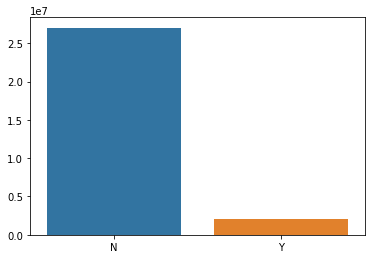

In [5]:
sns.barplot(index,values)

## Analysis for category_1
* The distribution is skewed with majority of the values being 'N'.
* Since the variance of this category is very less, it will hardly contribute alone to the feature set.

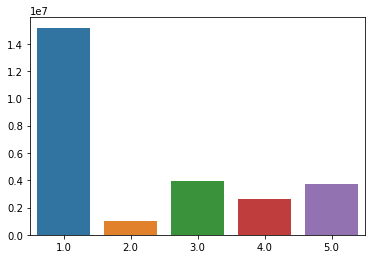

In [6]:
cat_2_count = hist_df['category_2'].value_counts()
index = cat_2_count.index
values = cat_2_count.values
sns.barplot(index,values)

## Analysis for category_2
* Even here one of the categories is higher in frequency as compared to other categories
* Other categories are almost equally distributed.

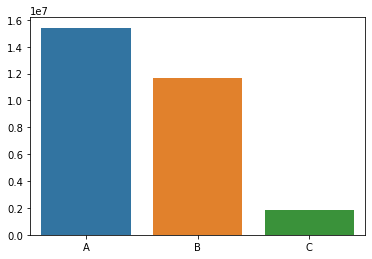

In [8]:
cat_3_count = hist_df['category_3'].value_counts()
index = cat_3_count.index
values = cat_3_count.values
sns.barplot(index,values)

## Analysis for category_3
* Category 'A' and 'B' contribute majorly to this series.

## 3. Let's import the train data
* We are doing this so that we can explore and find relations with target

In [14]:
df = pd.read_csv('train.csv')

In [15]:
train_df = df[['card_id','target']]
train_df['act_target'] = 2**train_df['target']

c:\users\capiot\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


* We know from the train data's eda that the target score contains outliers. 
* Let's remove those and use the remaining data for EDA.
* Also the actual target score is nothing but 2^target so let's obtain that and use it for our analysis.
   Source : https://www.kaggle.com/raddar/target-true-meaning-revealed

## 3.1 Objective : Checking on the distribution of target variable

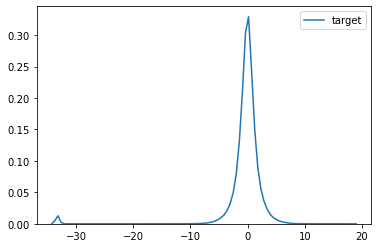

In [8]:
sns.kdeplot(train_df['target'])

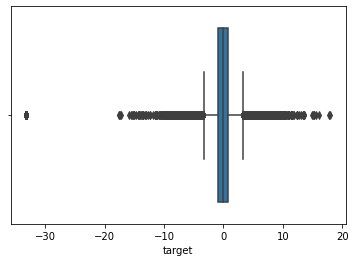

In [9]:
sns.boxplot('target',data = train_df)

## Analysis
* Let's use rows which have target values between -2 to 2 in order to get a zoomed view.
* We can see a small portion of target in the range of -30 these are outliers.

## Conclusion
* Will have to handle them carefully by detecting them and then predicting their target score.

In [37]:
nout_train_df = train_df[(train_df['target'] >= -2) & (train_df['target'] <= 2)]
print("Number of rows removed : ",train_df.shape[0]-nout_train_df.shape[0])
no_of_outliers = train_df.shape[0]-nout_train_df.shape[0]

Number of rows removed :  38386


In [38]:
print("Percentage of outliers removed : ",((no_of_outliers*100)/train_df.shape[0]))

Percentage of outliers removed :  19.010781657809893


In [80]:
nout_train_df['act_target'] = 2**nout_train_df['target']

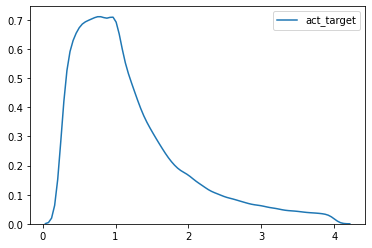

In [43]:
sns.kdeplot(nout_train_df['act_target'])

* Majority of the values lie in the range of 0-4 
* The distribution is right skewed.

## 4. Objective :  Check the relation between the categorical variables and target variable
* Since historical transactions contain several records for a single cardId over a period of several months, joining the train_df and hist_df is going to create a lot of null values.
* So we need to aggregate results across various columns in transactions_df so that while merging we don't see many null values.
* Also the target which is being used here is actual_target with transformed values.
* 20% of the data has been dropped since they form a small portion of extreme cases in target score.(not exactly outliers)

## 4.1 Objective :  Check relation of aggregated features on categorical attributes with target variable.
* In the below code snippet, we are calculating mode and unique number of categories for each of the categorical variable grouped by card_id

In [ ]:
cat_1_mode = hist_df.groupby('card_id')['category_1'].apply(lambda x : stats.mode(x)[0][0]).reset_index().rename(columns={'category_1':'cat_1_mode'})
cat_2_mode = hist_df.groupby('card_id')['category_2'].apply(lambda x : stats.mode(x)[0][0]).reset_index().rename(columns={'category_2':'cat_2_mode'})
cat_3_mode = hist_df.groupby('card_id')['category_3'].apply(lambda x : stats.mode(x)[0][0]).reset_index().rename(columns={'category_3':'cat_3_mode'})

cat_1_nunique = hist_df.groupby('card_id')['category_1'].apply(lambda x : x.nunique()).reset_index().rename(columns={'category_1':'cat_1_nc'})
cat_2_nunique = hist_df.groupby('card_id')['category_2'].apply(lambda x : x.nunique()).reset_index().rename(columns={'category_2':'cat_2_nc'})
cat_3_nunique = hist_df.groupby('card_id')['category_3'].apply(lambda x : x.nunique()).reset_index().rename(columns={'category_3':'cat_3_nc'})

In [ ]:
## Merging dataframes

cat_merge_df = pd.merge(nout_train_df,cat_1_mode,on='card_id',how='left')
cat_merge_df = pd.merge(cat_merge_df,cat_2_mode,on='card_id',how='left')
cat_merge_df = pd.merge(cat_merge_df,cat_3_mode,on='card_id',how='left')

cat_merge_df = pd.merge(cat_merge_df,cat_1_nunique,on='card_id',how='left')
cat_merge_df = pd.merge(cat_merge_df,cat_2_nunique,on='card_id',how='left')
cat_merge_df = pd.merge(cat_merge_df,cat_3_nunique,on='card_id',how='left')

cat_merge_df.head()

In [21]:
## Writing a generic piece of code which can help in studying categorical-numerical relation
## Typically all categories with target_score
## Referring the above code snippet as reference
def computeCategoricalAggr(nout_train_df,df,aggr_cat_col,lambda_func,col_suffix):
    """
    Input:
        df  : dataframe to be worked upon
aggr_cat_col: column to be aggregated
 lambda_func: lambda function to be applied
 col_suffix : suffix to be appended for column name
   Output:
       returns dataframe with categorical variable value and it's corresponding aggregate function value
    """
    cat_df = df.groupby('card_id')[aggr_cat_col].apply(lambda_func).reset_index().rename(columns={aggr_cat_col:aggr_cat_col + '_' + col_suffix})
    merge_df = pd.merge(nout_train_df,cat_df,on='card_id',how='inner')
    return merge_df

In [ ]:
## Dumping dataframe for further use
## because calculating it again will be cumbersome
import pickle
sampleFile = open('cat_merge_df','ab')
pickle.dump(cat_merge_df,sampleFile)
sampleFile.close()

In [7]:
sampleFile = open('cat_merge_df','rb')
cat_merge_df = pickle.load(sampleFile)
sampleFile.close()

### Plotting Box plots to show relationship between Modal aggregation on categorical features and target variable

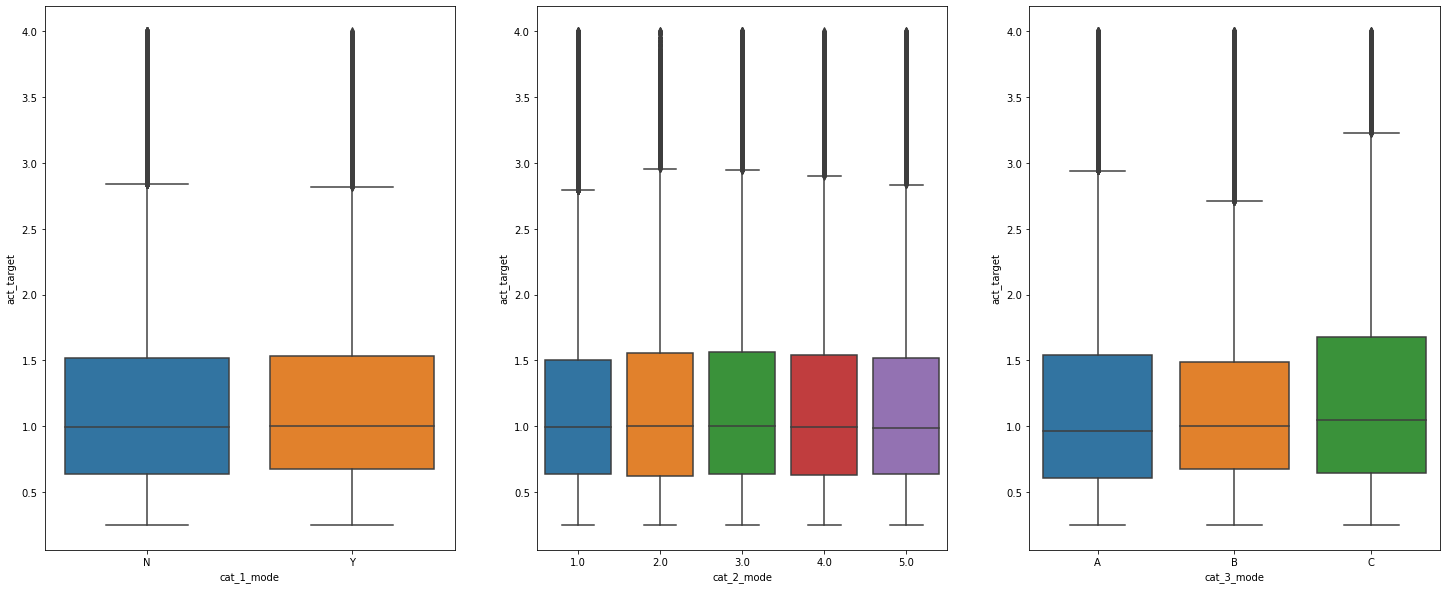

In [17]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25,10))
sns.boxplot('cat_1_mode','act_target',data=cat_merge_df,ax=ax1)
sns.boxplot('cat_2_mode','act_target',data=cat_merge_df,ax=ax2)
sns.boxplot('cat_3_mode','act_target',data=cat_merge_df,ax=ax3)

## Analysis
* Statistical mode on categorical features show slight variation in distribution of target variable.

## Conclusion
* It can be added to the feature set

### Plotting Box plots to show relationship between Nunique aggregation on categorical features and target variable

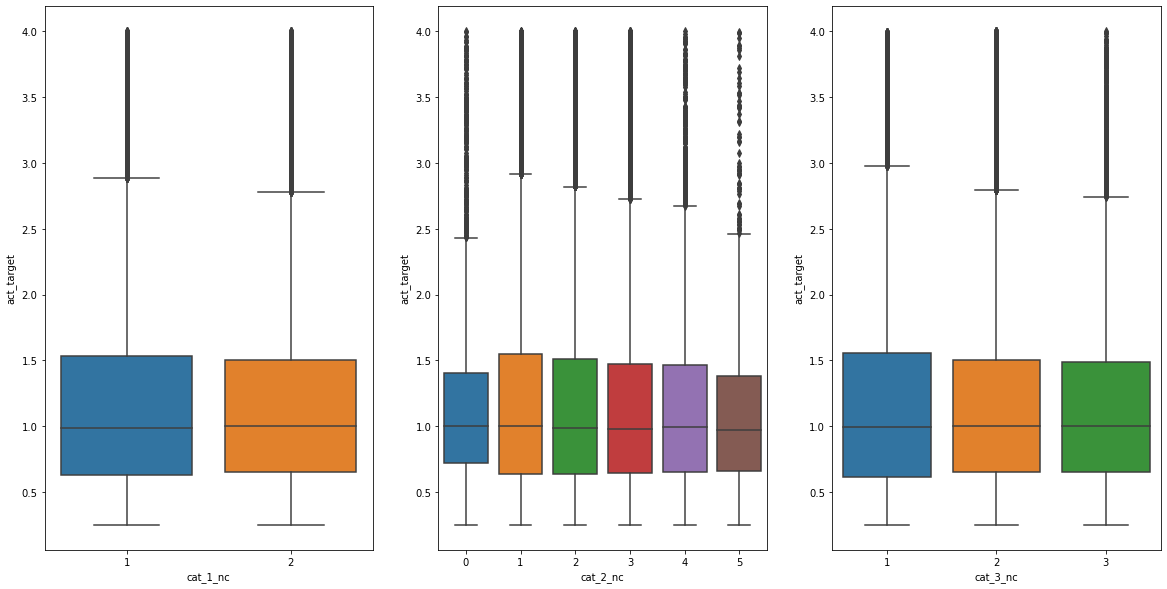

In [18]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(20,10))
sns.boxplot('cat_1_nc','act_target',data=cat_merge_df,ax=ax1)
sns.boxplot('cat_2_nc','act_target',data=cat_merge_df,ax=ax2)
sns.boxplot('cat_3_nc','act_target',data=cat_merge_df,ax=ax3)

## Analysis
* NUnique(Unique number of categories) on categorical features show slight variation in distribution of target variable.

## Conclusion
* It can be added to the feature set

## 4.2 Objective : Check relation between count based aggregation on categorical variable with target variable.

In [27]:
cat_1_cnt = hist_df.groupby('card_id')['category_1'].count().reset_index().rename(columns={'category_1':'cat_1_cnt'})
cat_2_cnt = hist_df.groupby('card_id')['category_2'].count().reset_index().rename(columns={'category_2':'cat_2_cnt'})
cat_3_cnt = hist_df.groupby('card_id')['category_3'].count().reset_index().rename(columns={'category_3':'cat_3_cnt'})

cat_merge_df = pd.merge(cat_merge_df,cat_1_cnt,on='card_id',how='left')
cat_merge_df = pd.merge(cat_merge_df,cat_2_cnt,on='card_id',how='left')
cat_merge_df = pd.merge(cat_merge_df,cat_3_cnt,on='card_id',how='left')

In [28]:
cat_merge_df.head()

,card_id,target,act_target,cat_1_mode,cat_2_mode,cat_3_mode,cat_1_nc,cat_2_nc,cat_3_nc,cat_1_cnt,cat_2_cnt,cat_3_cnt
0,C_ID_92a2005557,-0.820283,0.566331,N,1.0,A,1,2,2,260,260,260
1,C_ID_3d0044924f,0.392913,1.313042,N,1.0,B,2,1,2,350,319,348
2,C_ID_d639edf6cd,0.688056,1.611111,N,5.0,A,1,2,1,43,43,43
3,C_ID_186d6a6901,0.142495,1.103813,N,4.0,B,2,2,2,77,65,75
4,C_ID_cdbd2c0db2,-0.159749,0.895181,N,4.0,B,2,3,2,133,118,133


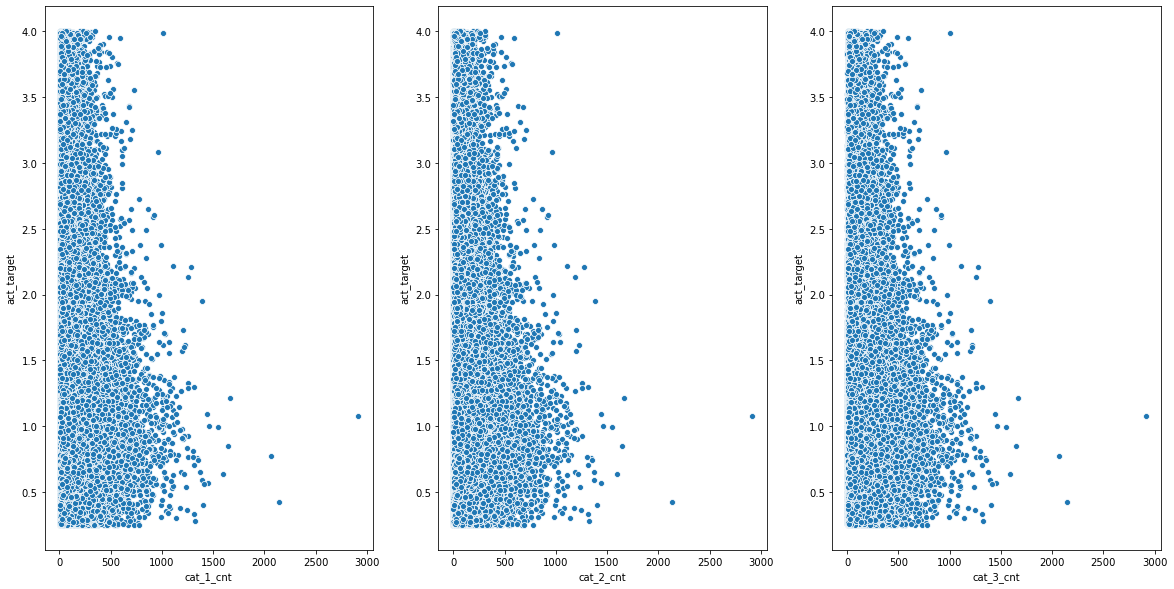

In [30]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(20,10))
sns.scatterplot('cat_1_cnt','act_target',data=cat_merge_df,ax=ax1)
sns.scatterplot('cat_2_cnt','act_target',data=cat_merge_df,ax=ax2)
sns.scatterplot('cat_3_cnt','act_target',data=cat_merge_df,ax=ax3)

## Analysis
* The scatterplot distribution is almost same and same kind of information is given by them.
* This is understandable because it just counts the number of categories grouped by card which is nothing but number of transactions done using the card.

## Conclusion
* Doesn't seem to be a useful feature.

In [32]:
abs(cat_merge_df[['cat_1_cnt','target']].corr())

,cat_1_cnt,target
cat_1_cnt,1.000000,0.040087
target,0.040087,1.000000


Even the correlation is less.

## 5 Objective : Study the relation between categorical variable and purchase amount

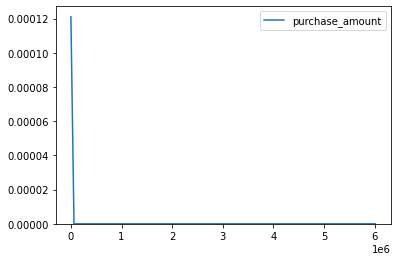

In [34]:
sns.kdeplot(hist_df['purchase_amount'])

In [28]:
## Writing a generic piece of code
## to obtain aggregate features for different categorical variables wrt to purchase amount

def generateAggrColumns(merge_df,df,groupby_col,aggr_col,aggr_funcs,col_prefix,isCardId=True):
    """
        Input: merge_df : df to be merged with
                     df : df whose columns will be used for groupby and aggregation
            groupby_col : column to be used for groupby
               aggr_col : column to be used for aggregation
               aggr_func: list of aggregate functions to be applied
             col_prefix : prefix to be applied for newly generated column name
               isCardId : if True then 'card_id' is used for groupby
               
        Output merge_df : merged df with aggregate columns
        
            Description : for each categorical value in categorical column we create a 
                          aggregate column with provided aggregate functions
                          for instance : category_1 contains two categories 'Y' and 'N'
                          and suppose aggregate function list contains min,max,median
                          then aggregate columns cat1_y_min,cat1_y_max,cat1_y_median
                          cat1_n_min,cat1_n_max,cat1_n_median will be created using groupby 
                          columns.
    """
    if isCardId:
        groupby = ['card_id'] + [groupby_col]
    
    aggr_dict = {aggr_col : aggr_funcs}
    for cat in tqdm(df[groupby_col].unique()):
        aggr_prefix = {aggr_col : col_prefix + '_' + str(cat)}
        temp_df = df[df[groupby_col]==cat].groupby(groupby).agg(aggr_dict).reset_index().rename(columns=aggr_prefix)
        temp_df.columns = ['_'.join(col).strip('_') for col in temp_df.columns.values]
        temp_df.drop([groupby_col],axis = 1,inplace = True)
        merge_df = pd.merge(merge_df,temp_df,on='card_id',how='left')
    return merge_df

In [39]:
aggr_col = 'new_purchase_amount'
aggr_funcs = ['min','max','median','sum']
cat_cols = ['category_1','category_2','category_3']
firstRun = True

for cat_col in cat_cols:
    temp_df = generateAggrColumns(train_df,hist_df,cat_col,aggr_col,aggr_funcs,cat_col + '_purch_')
    if firstRun:
        merge_df = temp_df
        firstRun = False
    else:
        merge_df = pd.merge(merge_df,temp_df,on='card_id',how='left')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.01s/it]


None of the aggregated columns show any high linear correlation with target variable.

In [ ]:
def removeMissingValuesColumns(df,missing_perc=0.5):
    """
              df : dataframe to be considered for removing missing values
    missing_perc : filter to decide columns which should be removed with 
                   percentage of missing values greater than the passed value  
          Output : Plots Heatmap for dataframe 
    """
    null_val_col = (df.isnull().sum()/df.shape[0] >= missing_perc).reset_index().rename(columns= {'index' : 'cols',0 : 'bool'})
    cols = null_val_col[null_val_col['bool'] == False]['cols'].values
    fig,ax = plt.subplots(figsize = (15,10))
    sns.heatmap(abs(df[cols].corr()),ax=ax)
    return df[cols]

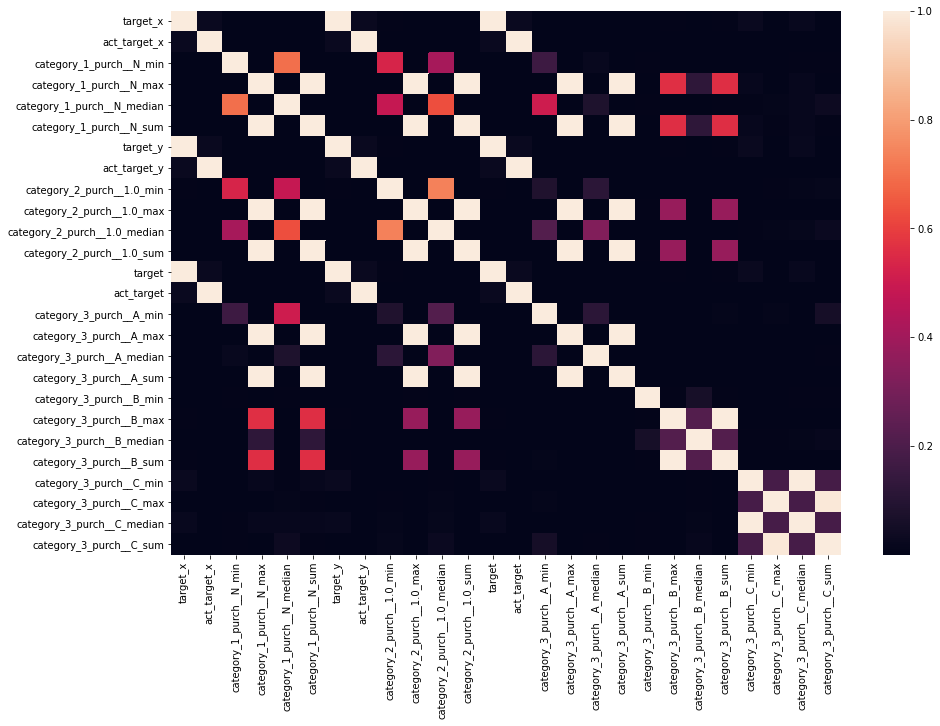

In [38]:
filtered_df = removeMissingValuesColumns(merge_df)

## Analysis
* No Strong correlation of the newly formed features with the target variable.

## Conclusion
* Above aggregated features won't be of that much help.

## 6. Objective : Explore city_id & state_id

In [20]:
## Let's write a generic function to display barplots
def plotBarPlot(df,col,quantile=0):
    """
          df: dataframe which contains the column to be aggregated
         col: column which is used for counting the number of categories
    quantile: used as a filter to display the number of categories starting from count of 0th quantile as default  
    """
    qq = np.percentile(df[col].value_counts().values,q=quantile)
    id_counts = df[col].value_counts().reset_index().rename(columns = {col : 'count'}).sort_values(by=['count'])
    filtered_data = id_counts[id_counts['count'] >= qq]
    
    #Plotting the barplot
    fig,ax = plt.subplots(figsize = (15,10))
    sns.barplot('index','count',data = filtered_data,ax=ax)
    plt.xlabel(col)
    plt.xticks(rotation = 90)

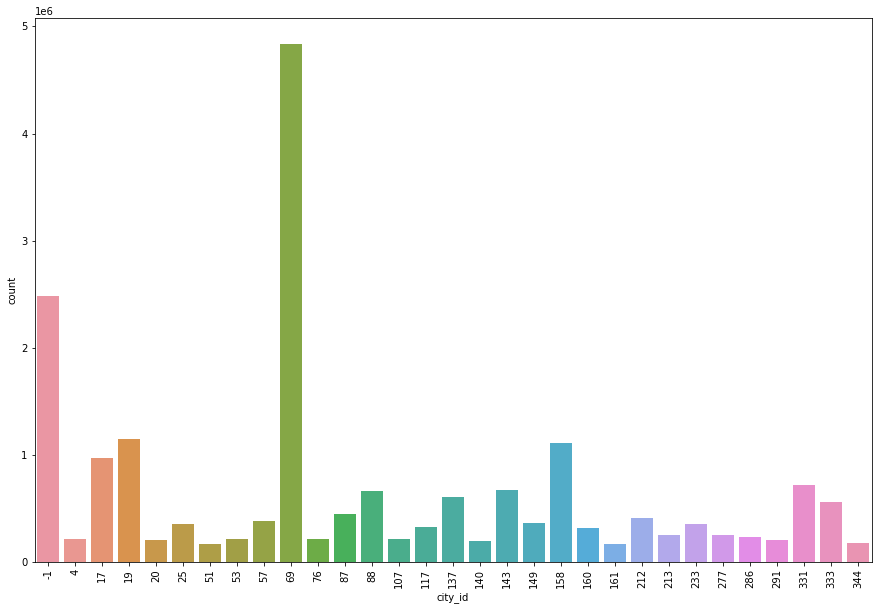

In [49]:
plotBarPlot(hist_df,'city_id',90)

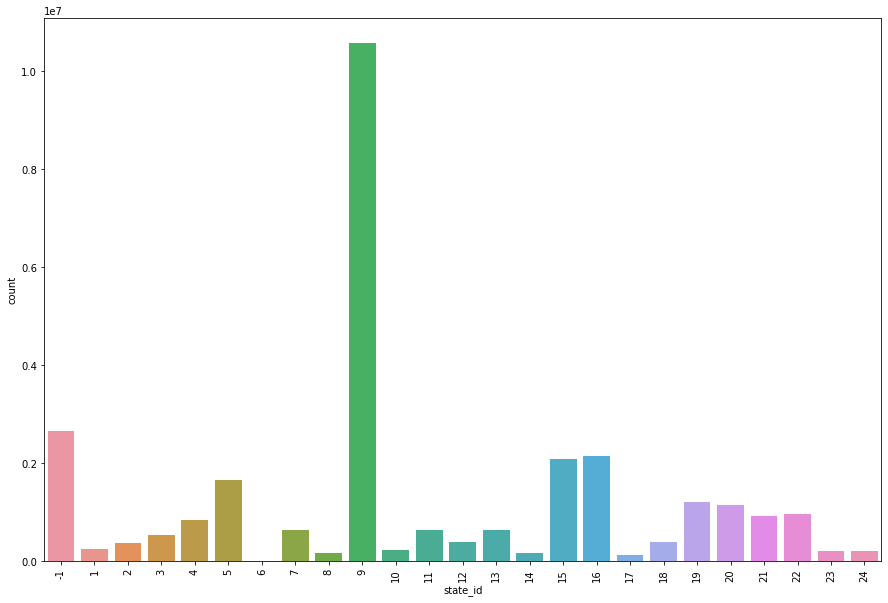

In [50]:
plotBarPlot(hist_df,'state_id')

## Analysis
* Maximum of the card_id's have been used in the state with state_id = 9
* Maximum of the card_id's have been used in the city with city_id = 69

## 6.1 Objective : Check relation of aggregation on state_id and city_id with target variable

In [57]:
## Function call to compute mode for state_id and city_id grouped by card_id
state_mode_df = computeCategoricalAggr(nout_train_df,hist_df,'state_id',mode_lambda_func,'mode')
city_mode_df = computeCategoricalAggr(nout_train_df,hist_df,'city_id',mode_lambda_func,'mode')

# Function call to compute nunique for state_id and city_id grouped by card_id
state_nunique_df = computeCategoricalAggr(nout_train_df,hist_df,'state_id',nunique_lambda_func,'nunique')
city_nunique_df = computeCategoricalAggr(nout_train_df,hist_df,'city_id',nunique_lambda_func,'nunique')

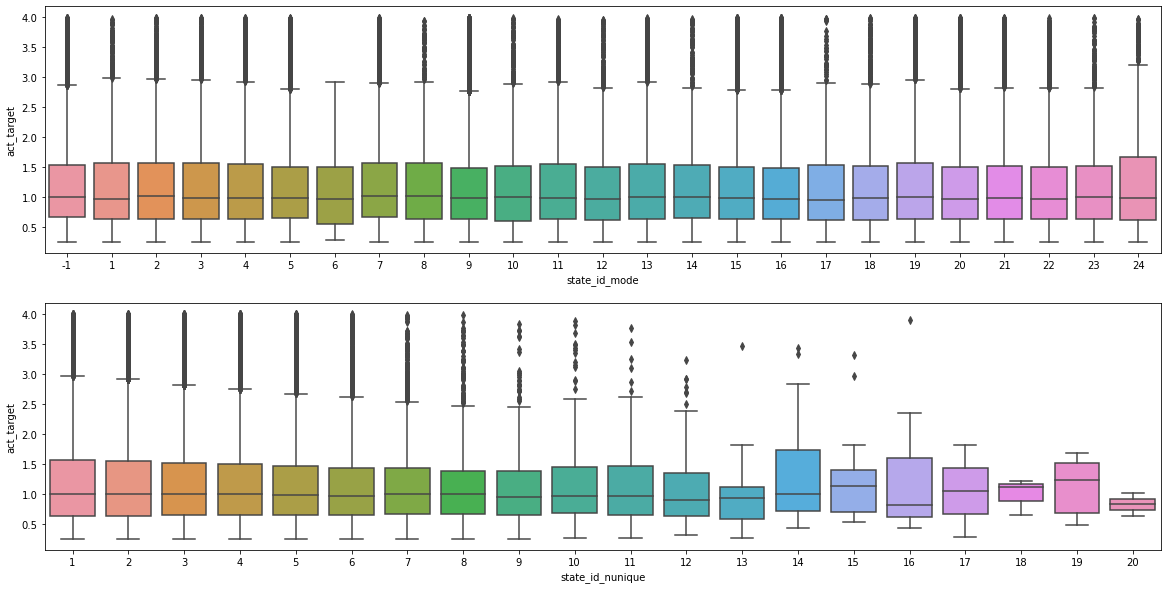

In [60]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols = 1,figsize = (20,10))

sns.boxplot(x='state_id_mode',y = 'act_target',data = state_mode_df,ax = ax1)
sns.boxplot(x='state_id_nunique',y = 'act_target',data = state_nunique_df,ax = ax2)

## Analysis
* State_id_mode and state_id_nunique show some variation in distribution of target variable wrt to different category values.

## Conclusion
* These aggregated features will be useful to our feature set.

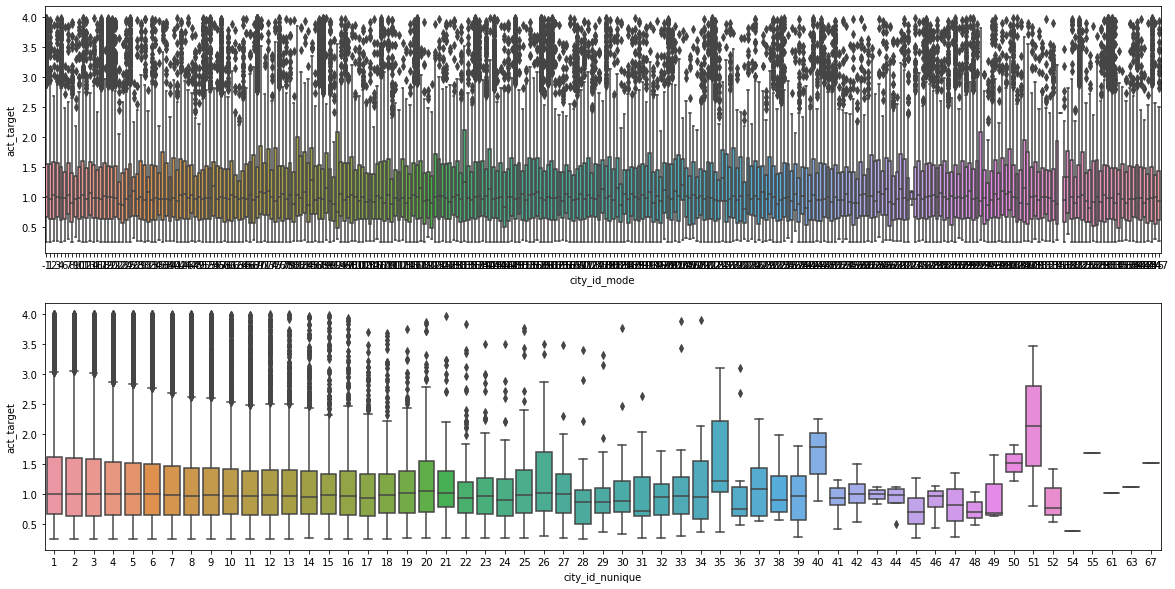

In [61]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols = 1,figsize = (20,10))

sns.boxplot(x='city_id_mode',y = 'act_target',data = city_mode_df,ax = ax1)
sns.boxplot(x='city_id_nunique',y = 'act_target',data = city_nunique_df,ax = ax2)

## Analysis
* City_id_mode and city_id_nunique show some variation in distribution of target variable wrt to different category values.

## Conclusion
* These aggregated features will be useful to our feature set

## 7. Objective : Explore Authorized flag
* Our main objective here is to observe how authorized flag when grouped by card_id is related to target variable.
* For which we perform various aggregation operation on authorized flag and then come up with boxplots in case of categorical aggregation and regplot in case of numerical aggregation.


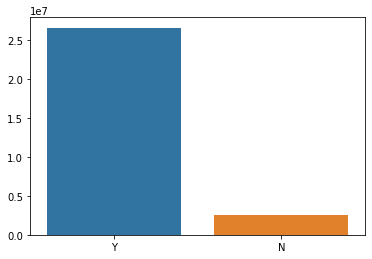

In [64]:
auth_flag_counts = hist_df['authorized_flag'].value_counts()
index = auth_flag_counts.index
value = auth_flag_counts.values
sns.barplot(index,value)

## Analysis
* Only a small percentage of transactions aren't authorized.

## Conclusion
* During feature creation we might create a seperate dataset with authorized flag = 1 and build features on top of it.

In [70]:
## Referring to previous two lambda functions
auth_mode_df = computeCategoricalAggr(nout_train_df,hist_df,aggr_cat_col='authorized_flag',lambda_func=mode_lambda_func,col_suffix='mode')
auth_nunique_df = computeCategoricalAggr(nout_train_df,hist_df,aggr_cat_col='authorized_flag',lambda_func=nunique_lambda_func,col_suffix='nunique')

In [81]:
## In this cell we are aggregating authorized_flag with count of Y's.
auth_lambda_func = lambda x : x[x == 'Y'].count()
auth_count_df = computeCategoricalAggr(nout_train_df,hist_df,aggr_cat_col='authorized_flag',lambda_func=auth_lambda_func,col_suffix='count')

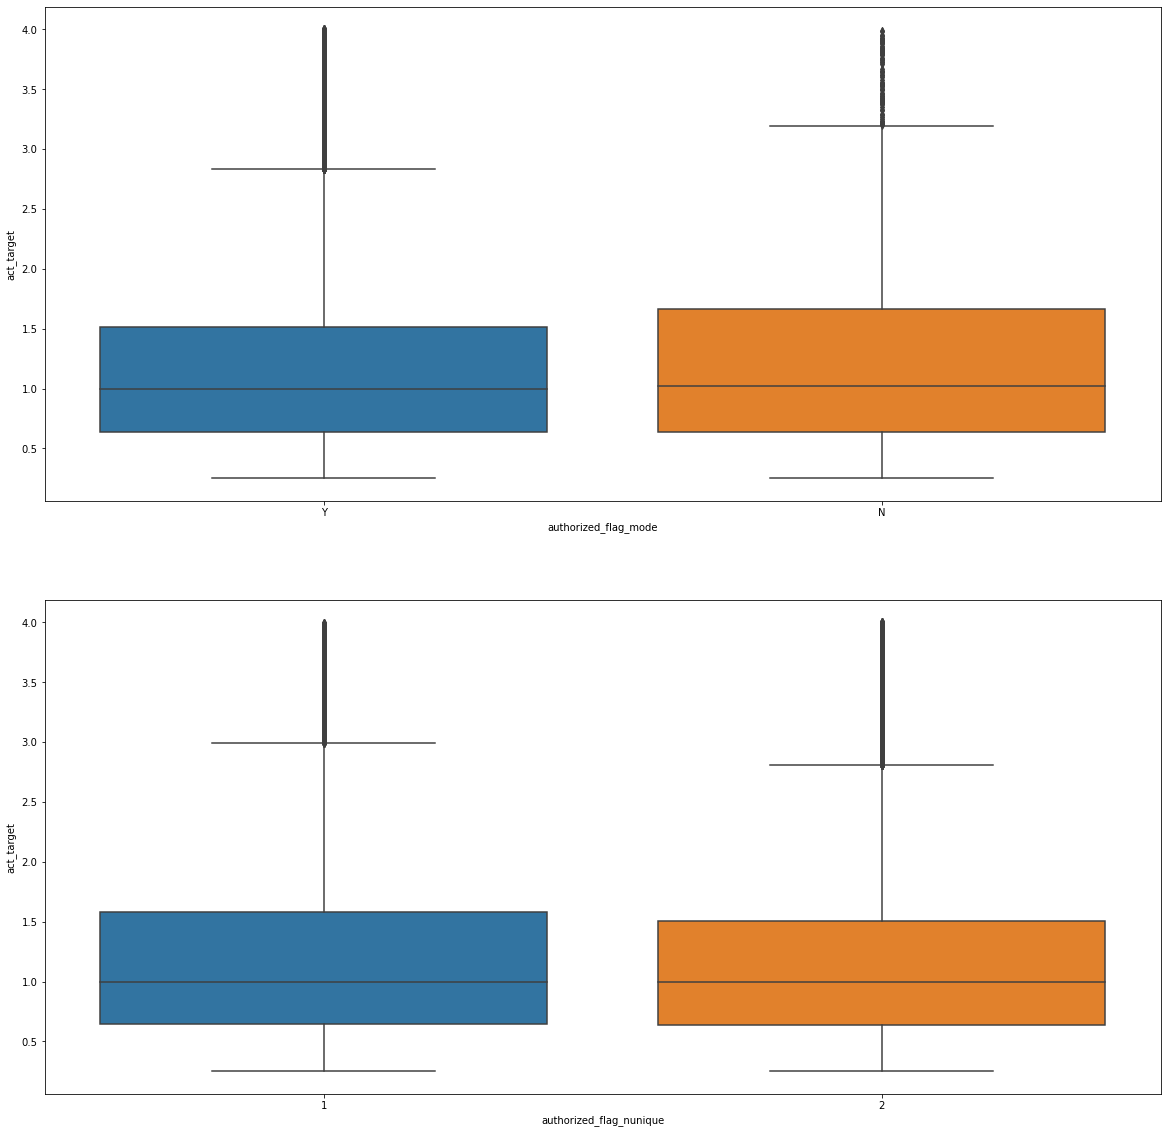

In [84]:
## Performing boxplots wrt target variable
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols = 1,figsize = (20,20))

sns.boxplot(x='authorized_flag_mode',y = 'act_target',data = auth_mode_df,ax = ax1)
sns.boxplot(x='authorized_flag_nunique',y = 'act_target',data = auth_nunique_df,ax = ax2)

## Analysis
* Authorized flag with nunique values as aggregation shows almost same distribution wrt target variable.
* Authorized flag with mode of the categorical variable also shows same distribution.

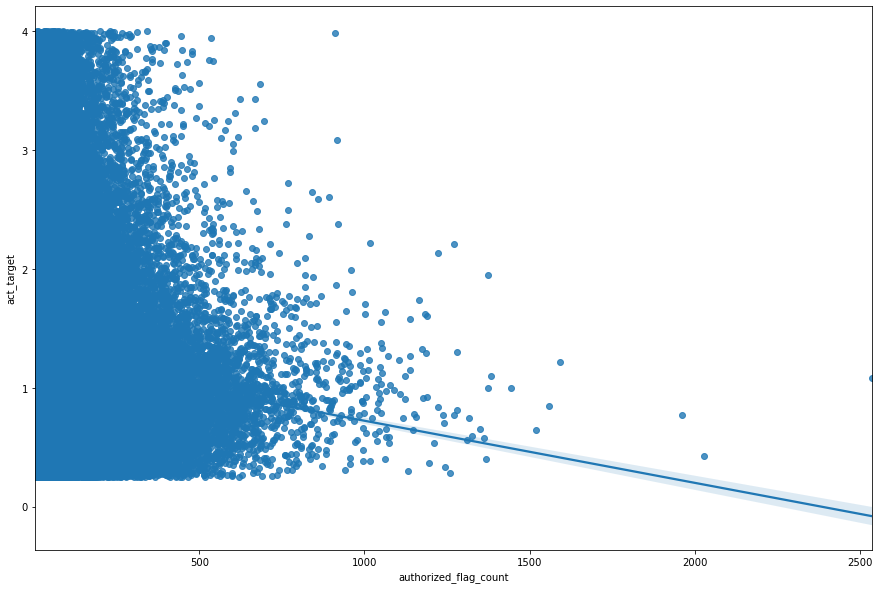

In [85]:
# Performing regression plot wrt target variable
fig,ax = plt.subplots(figsize = (15,10))
sns.regplot(x='authorized_flag_count',y = 'act_target',data = auth_count_df,ax = ax)

## Analysis
* Regression plot of authorized flag with count of Y's and target variable shows no significant trend on lower counts of Y's but with more number of authorized transactions for a particular card it can be seen that there is general decline in the actual target.
* With Authorized flag we can later form separate dataset with rows containing authorized_flag='Y' and apply same kind of aggregation as we are applying now and observe if features generated by this method contribute anything significant to the model that will be built.

## 8. Objective : Exploring other categorical variables (merchant_category_id, subsector_id)

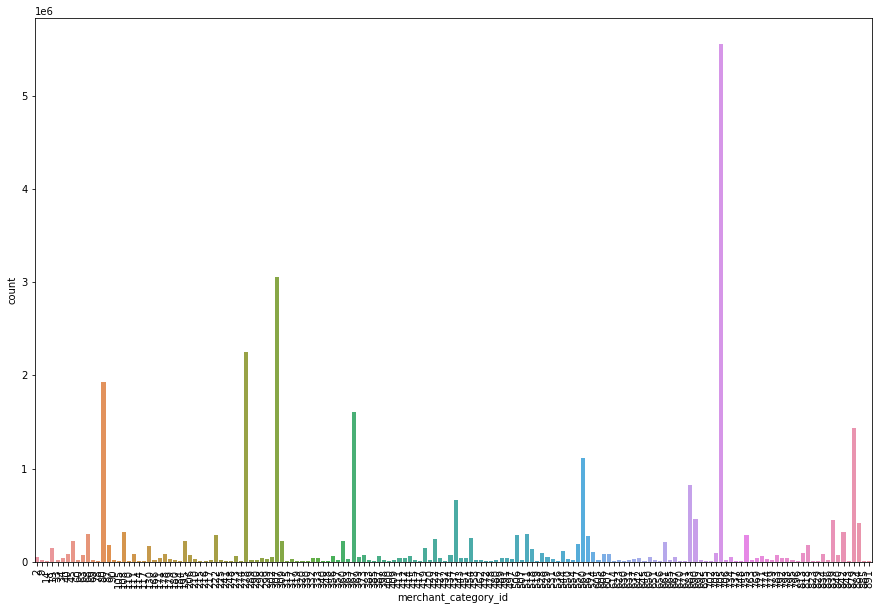

In [52]:
plotBarPlot(hist_df,'merchant_category_id',50)

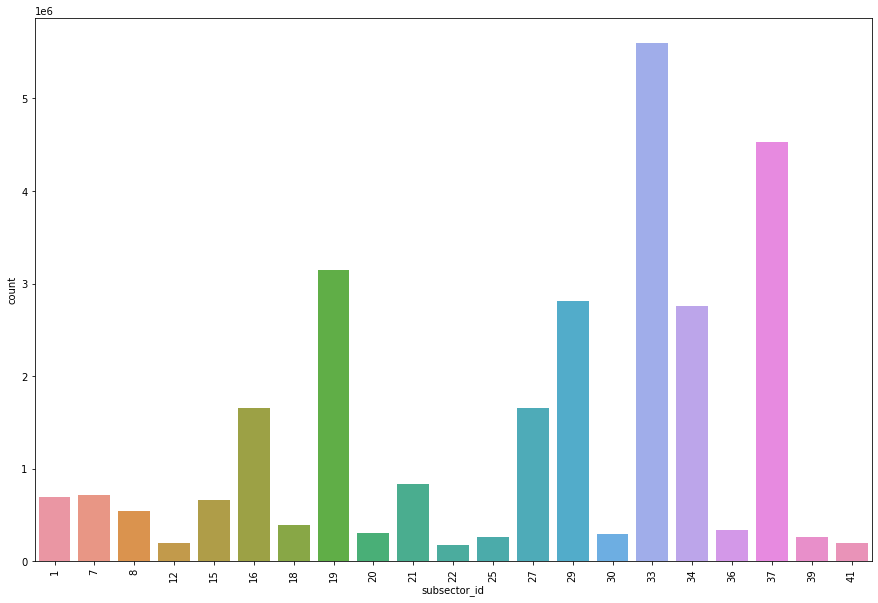

In [53]:
plotBarPlot(hist_df,'subsector_id',50)

## Analysis
* Since the number of categories in each of this columns is high.
* I am just plotting the count of each of the category with value greater than 50th percentile in the aggregated column.
* It shows some important deal of information that for certain categorical variables the count is bit higher as compared to other categorical values. 

## 8.1 Objective : Check relation between aggregated feature on Subsector_id and target variable

In [96]:
## Referring to previous two lambda functions
subsector_mode_df = computeCategoricalAggr(nout_train_df,hist_df,aggr_cat_col='subsector_id',lambda_func=mode_lambda_func,col_suffix='mode')
subsector_nunique_df = computeCategoricalAggr(nout_train_df,hist_df,aggr_cat_col='subsector_id',lambda_func=nunique_lambda_func,col_suffix='nunique')

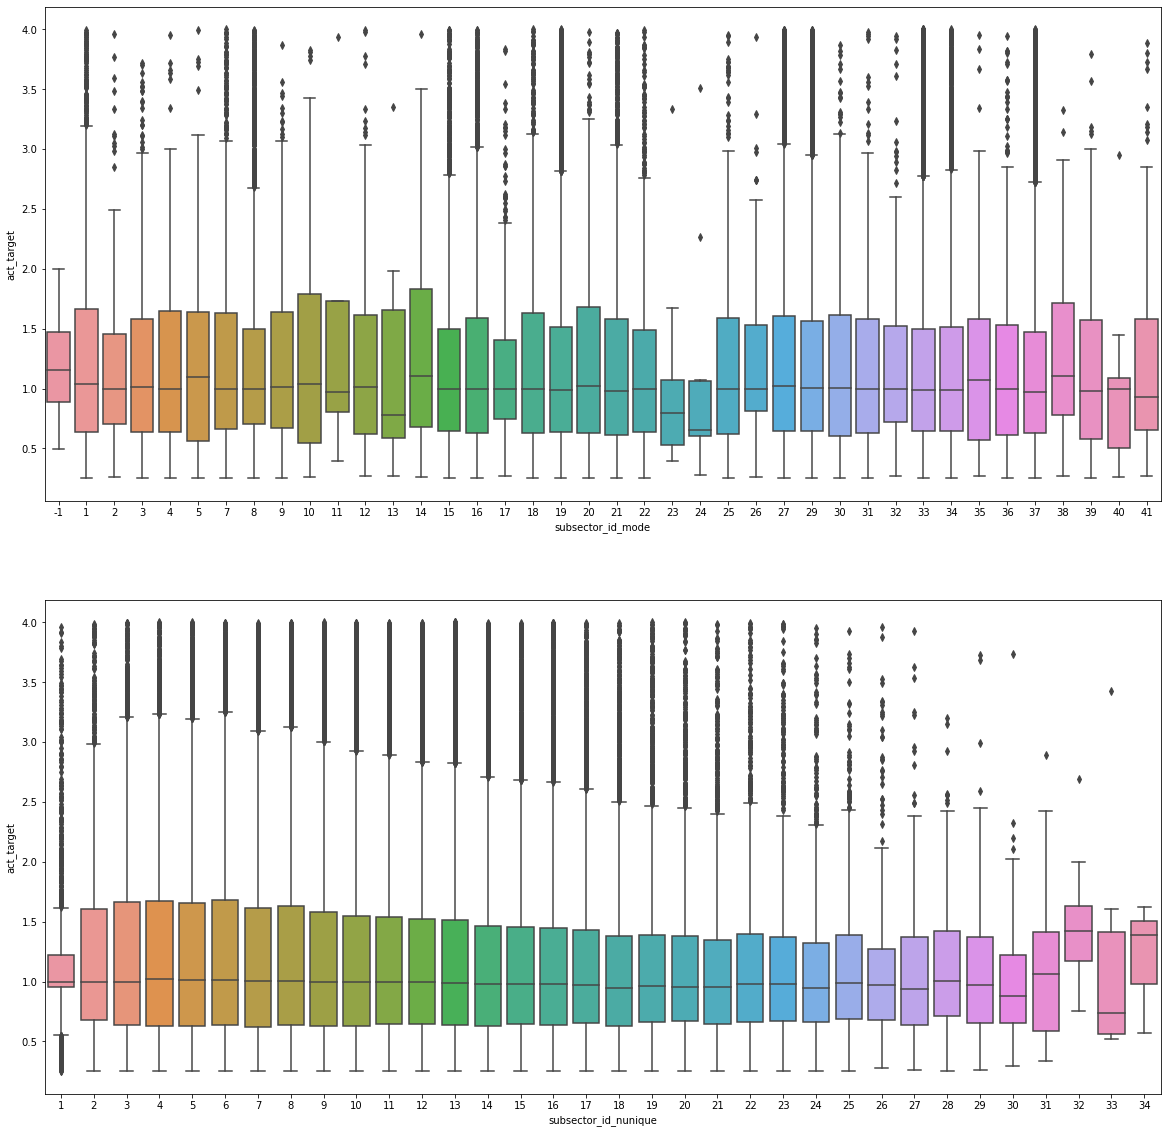

In [97]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols = 1,figsize = (20,20))

sns.boxplot(x='subsector_id_mode',y = 'act_target',data = subsector_mode_df,ax = ax1)
sns.boxplot(x='subsector_id_nunique',y = 'act_target',data = subsector_nunique_df,ax = ax2)

## Analysis
* Even this subsector_id's aggregation over mode and nunique gives some deviation in distribution wrt target variable.

## Conclusion
* This features will be useful for our feature set.

## 8.1 Objective : Check relation between aggregated feature on merchant_category_id and target variable

In [102]:
## Referring to previous two lambda functions
merch_cat_mode_df = computeCategoricalAggr(nout_train_df,hist_df,aggr_cat_col='merchant_category_id',lambda_func=mode_lambda_func,col_suffix='mode')
merch_cat_nunique_df = computeCategoricalAggr(nout_train_df,hist_df,aggr_cat_col='merchant_category_id',lambda_func=nunique_lambda_func,col_suffix='nunique')

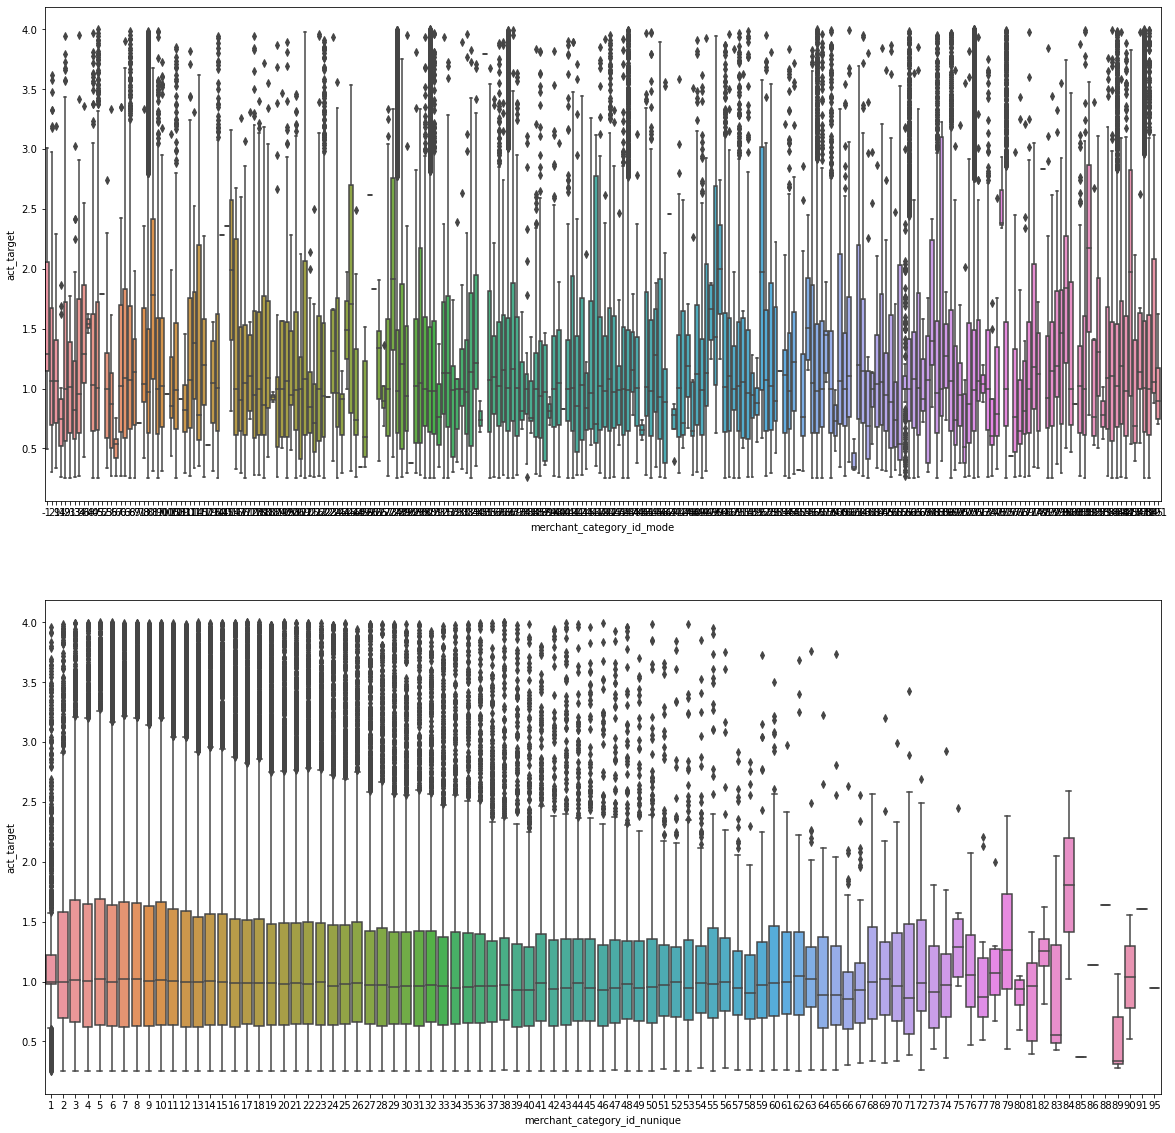

In [103]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols = 1,figsize = (20,20))

sns.boxplot(x='merchant_category_id_mode',y = 'act_target',data = merch_cat_mode_df,ax = ax1)
sns.boxplot(x='merchant_category_id_nunique',y = 'act_target',data = merch_cat_nunique_df,ax = ax2)

## Analysis
* There's good overlap but also a good amount of deviation  as well in distribution of target variable wrt different categories.

## Conclusion
* This features will be useful for our feature set.

## 9. Objective : Explore Installments,purchase_amount,purchase_date,month_lag

In [9]:
## Creating a sample of train_df
nout_train_df = train_df[(train_df['act_target'] >= -2) & (train_df['act_target'] <= 2)]

In [74]:
## Sampling a small subset of columns from historical transactions
temp_df = hist_df[['card_id','installments','new_purchase_amount','purchase_date','month_lag']].copy()

In [75]:
temp_df.head()

,card_id,installments,new_purchase_amount,purchase_date,month_lag
0,C_ID_4e6213e9bc,0,29.00,2017-06-25 15:33:07,-8
1,C_ID_4e6213e9bc,0,9.17,2017-07-15 12:10:45,-7
2,C_ID_4e6213e9bc,0,17.65,2017-08-09 22:04:29,-6
3,C_ID_4e6213e9bc,0,7.69,2017-09-02 10:06:26,-5
4,C_ID_4e6213e9bc,0,16.00,2017-03-10 01:14:19,-11


In [14]:
## Checking the datatype of purhcase_date
type(temp_df['purchase_date'][0])

str

### Converting str format to datetime format and obtaining other date related features like day,weekday, year and month

In [15]:
hist_df['purchase_date'] = pd.to_datetime(temp_df['purchase_date'])
temp_df['day'] = hist_df['purchase_date'].dt.day
temp_df['wday'] = hist_df['purchase_date'].dt.weekday
temp_df['year'] = hist_df['purchase_date'].dt.year
temp_df['month'] = hist_df['purchase_date'].dt.month

In [16]:
temp_df.head()

,card_id,installments,new_purchase_amount,purchase_date,month_lag,day,wday,year,month
0,C_ID_4e6213e9bc,0,29.00,2017-06-25 15:33:07,-8,25,6,2017,6
1,C_ID_4e6213e9bc,0,9.17,2017-07-15 12:10:45,-7,15,5,2017,7
2,C_ID_4e6213e9bc,0,17.65,2017-08-09 22:04:29,-6,9,2,2017,8
3,C_ID_4e6213e9bc,0,7.69,2017-09-02 10:06:26,-5,2,5,2017,9
4,C_ID_4e6213e9bc,0,16.00,2017-03-10 01:14:19,-11,10,4,2017,3


## 9.1 Objective : Check relation between month lag and actual target

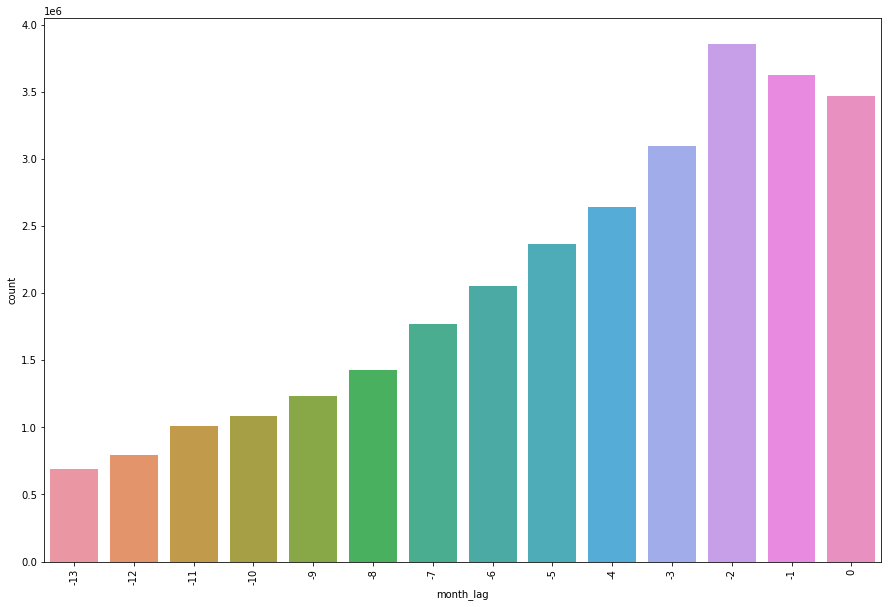

In [29]:
plotBarPlot(temp_df,col = 'month_lag')

## Analysis
* A lag of 0 suggests latest month of transaction whereas a lag of -1 represents transactions of previous month wrt reference date.
* There have been more recent purchases as compared to previous months.

## 9.2 Check relation between aggregated feature on month lag and target variable

In [31]:
month_lag_mode = computeCategoricalAggr(nout_train_df,temp_df,'month_lag',mode_lambda_func,'mode')
month_lag_nunique = computeCategoricalAggr(nout_train_df,temp_df,'month_lag',nunique_lambda_func,'nunique')

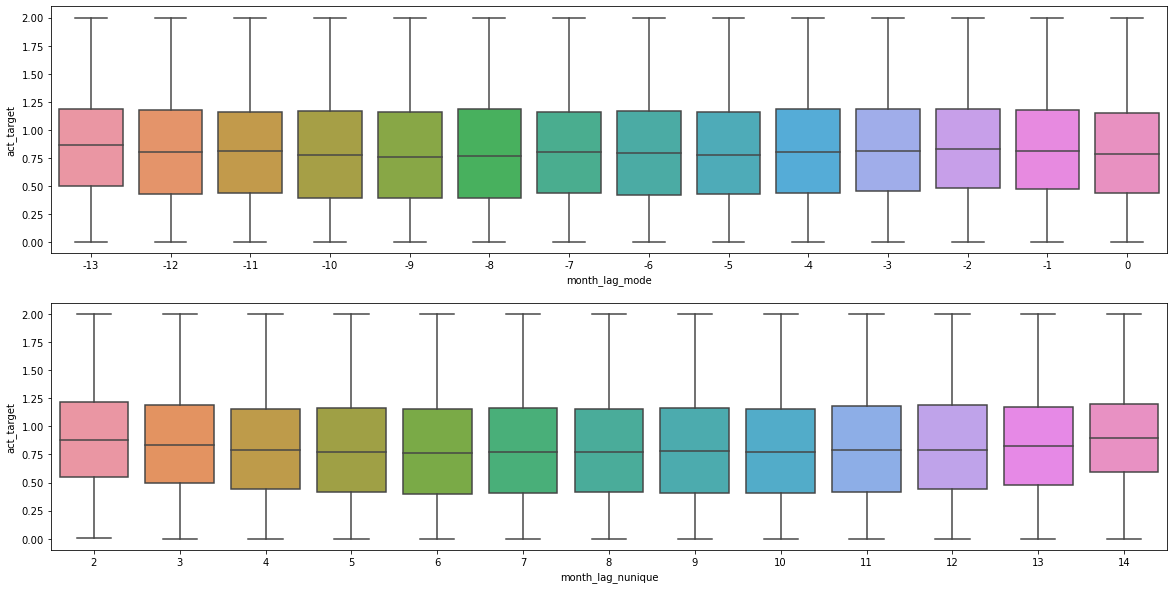

In [32]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols = 1,figsize = (20,10))

sns.boxplot(x='month_lag_mode',y = 'act_target',data = month_lag_mode,ax = ax1)
sns.boxplot(x='month_lag_nunique',y = 'act_target',data = month_lag_nunique,ax = ax2)

## Analysis
* Month lag's aggregation over mode and nunique gives some deviation in distribution wrt target variable.

## Conclusion
* This features will be useful for our feature set.

## 9.3 Let's look at the relation between purchase day and actual_target

In [55]:
temp_df.head()

,card_id,installments,new_purchase_amount,purchase_date,month_lag,day,wday,year,month
0,C_ID_4e6213e9bc,0,29.00,2017-06-25 15:33:07,-8,25,6,2017,6
1,C_ID_4e6213e9bc,0,9.17,2017-07-15 12:10:45,-7,15,5,2017,7
2,C_ID_4e6213e9bc,0,17.65,2017-08-09 22:04:29,-6,9,2,2017,8
3,C_ID_4e6213e9bc,0,7.69,2017-09-02 10:06:26,-5,2,5,2017,9
4,C_ID_4e6213e9bc,0,16.00,2017-03-10 01:14:19,-11,10,4,2017,3


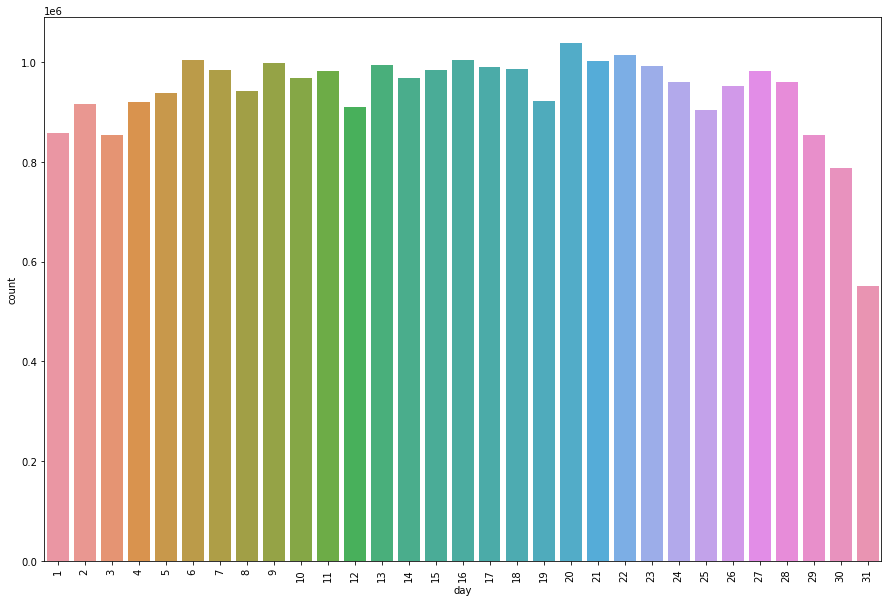

In [66]:
plotBarPlot(temp_df,'day')

## Analysis
* No much variation in number of transactions with days of the month

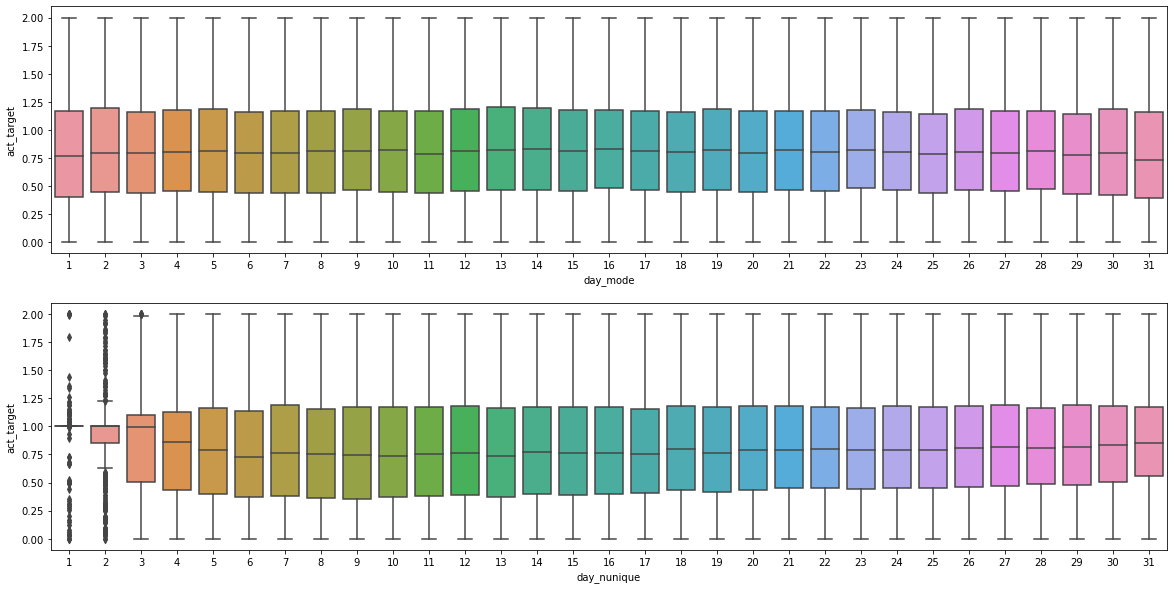

In [67]:
day_mode = computeCategoricalAggr(nout_train_df,temp_df,'day',mode_lambda_func,'mode')
day_nunique = computeCategoricalAggr(nout_train_df,temp_df,'day',nunique_lambda_func,'nunique')

fig,(ax1,ax2) = plt.subplots(nrows=2,ncols = 1,figsize = (20,10))
sns.boxplot(x='day_mode',y = 'act_target',data = day_mode,ax = ax1)
sns.boxplot(x='day_nunique',y = 'act_target',data = day_nunique,ax = ax2)

## Analysis
* Mode and Nunique show slight variation in distribution of target variable wrt different categories of data.

In [68]:
aggr_col = 'new_purchase_amount'
aggr_funcs = ['min','max','median','sum']

generateAggrColumns(nout_train_df,temp_df,'day',aggr_col,aggr_funcs,'purch_')

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:49<00:00,  1.61s/it]


,card_id,target,act_target,purch__25_min,purch__25_max,purch__25_median,purch__25_sum,purch__15_min,purch__15_max,purch__15_median,...,purch__12_median,purch__12_sum,purch__28_min,purch__28_max,purch__28_median,purch__28_sum,purch__4_min,purch__4_max,purch__4_median,purch__4_sum
0,C_ID_92a2005557,-0.820283,0.566331,27.990000,160.300003,110.805000,569.719971,10.000000,209.619995,34.000000,...,67.989998,760.320007,20.000000,195.800003,29.900000,693.919983,9.00,180.029999,50.000000,717.289978
1,C_ID_3d0044924f,0.392913,1.313042,4.000000,169.000000,19.000000,720.169983,3.000000,219.800003,14.375000,...,34.750000,756.520020,4.000000,87.779999,13.000000,377.929993,7.50,99.900002,28.000000,135.399994
2,C_ID_d639edf6cd,0.688056,1.611111,20.930000,30.590000,25.760000,51.520000,12.000000,24.010000,18.005001,...,NaN,NaN,31.059999,39.540001,35.299999,70.599998,NaN,NaN,NaN,NaN
3,C_ID_186d6a6901,0.142495,1.103813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.500000,65.000000,34.900002,164.230011,11.75,42.000000,25.900000,79.650002
4,C_ID_cdbd2c0db2,-0.159749,0.895181,53.500000,593.960022,73.919998,721.380005,24.500000,91.800003,27.615000,...,118.139999,1661.069946,7.000000,5150.580078,22.049999,5282.620117,22.83,50.310001,27.799999,100.940002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161012,C_ID_963962de2c,-2.740821,0.149600,NaN,NaN,NaN,NaN,5.620000,11.880000,8.750000,...,4.470000,4.470000,NaN,NaN,NaN,NaN,3.77,3.770000,3.770000,3.770000
161013,C_ID_1314773c0b,0.312917,1.242217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.590000,3.590000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161014,C_ID_7666735b3d,0.093494,1.066951,99.900002,169.600006,134.750000,269.500000,107.290001,107.290001,107.290001,...,79.175003,158.350006,47.500000,1290.000000,668.750000,1337.500000,8.00,60.000000,30.500000,98.500000
161015,C_ID_73f5a0efd0,-4.676589,0.039103,10.000000,37.250000,10.000000,57.250000,NaN,NaN,NaN,...,NaN,NaN,23.750000,28.490000,26.119999,52.239998,34.00,91.430000,62.715000,125.430000


## 9.4 Objective : Relation between purchase month and actual target

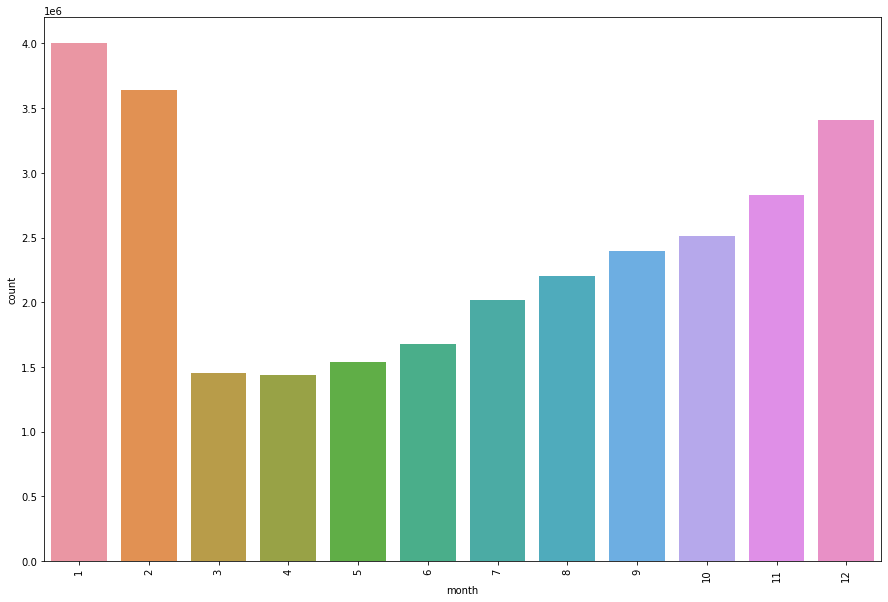

In [69]:
plotBarPlot(temp_df,'month')
month_mode = computeCategoricalAggr(nout_train_df,temp_df,'month',mode_lambda_func,'mode')
month_nunique = computeCategoricalAggr(nout_train_df,temp_df,'month',nunique_lambda_func,'nunique')

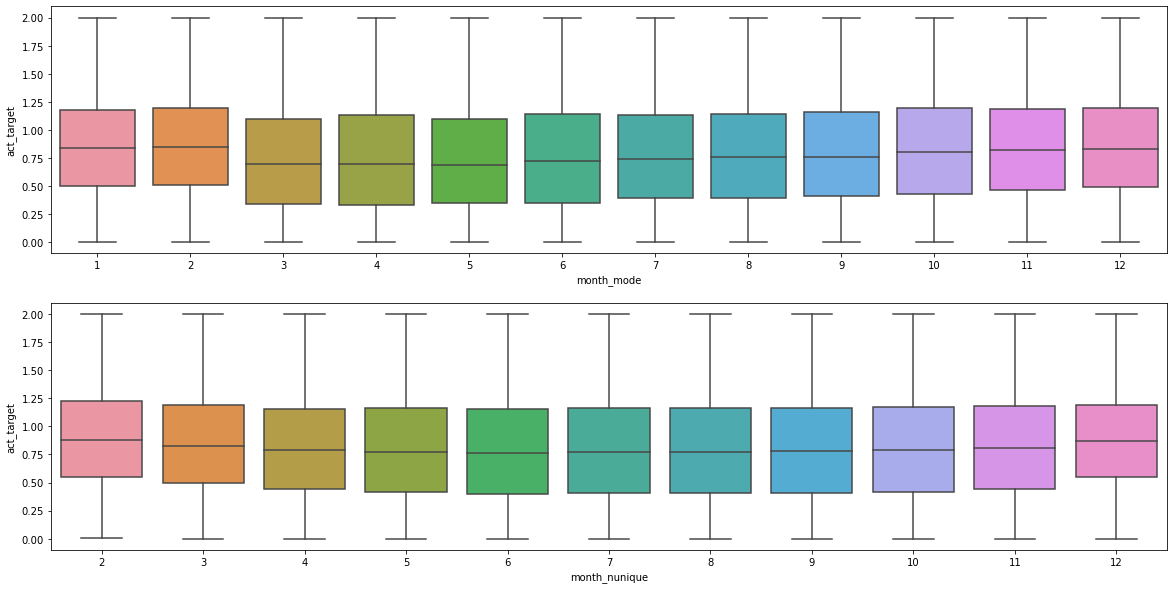

In [70]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols = 1,figsize = (20,10))
sns.boxplot(x='month_mode',y = 'act_target',data = month_mode,ax = ax1)
sns.boxplot(x='month_nunique',y = 'act_target',data = month_nunique,ax = ax2)

In [71]:
generateAggrColumns(nout_train_df,temp_df,'month',aggr_col,aggr_funcs,'purch_')

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it]


,card_id,target,act_target,purch__6_min,purch__6_max,purch__6_median,purch__6_sum,purch__7_min,purch__7_max,purch__7_median,...,purch__1_median,purch__1_sum,purch__4_min,purch__4_max,purch__4_median,purch__4_sum,purch__12_min,purch__12_max,purch__12_median,purch__12_sum
0,C_ID_92a2005557,-0.820283,0.566331,24.209999,51.610001,36.930000,112.750000,10.00,292.600006,30.000000,...,44.820000,1425.839966,NaN,NaN,NaN,NaN,8.700000,2000.000000,70.000000,8178.189941
1,C_ID_3d0044924f,0.392913,1.313042,6.000000,350.429993,22.000000,1897.699951,4.59,1257.199951,19.000000,...,18.000000,7531.129883,7.400000,548.890015,65.379997,2050.800049,3.000000,721.070007,13.500000,2256.739990
2,C_ID_d639edf6cd,0.688056,1.611111,NaN,NaN,NaN,NaN,22.91,43.470001,33.190002,...,32.980000,646.020020,22.780001,68.550003,30.250000,273.730011,26.020000,26.020000,26.020000,26.020000
3,C_ID_186d6a6901,0.142495,1.103813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.989998,453.839996,NaN,NaN,NaN,NaN,6.000000,187.830002,41.235001,362.290009
4,C_ID_cdbd2c0db2,-0.159749,0.895181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.275002,3656.800049,NaN,NaN,NaN,NaN,0.500000,200.000000,55.000000,2161.790039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161012,C_ID_963962de2c,-2.740821,0.149600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.125000,135.069992,NaN,NaN,NaN,NaN,3.000000,100.000000,18.740000,287.029999
161013,C_ID_1314773c0b,0.312917,1.242217,59.900002,59.900002,59.900002,59.900002,4.40,88.000000,9.200000,...,12.000000,109.839996,NaN,NaN,NaN,NaN,5.000000,9.050000,5.150000,24.350000
161014,C_ID_7666735b3d,0.093494,1.066951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,106.250000,401.899994,NaN,NaN,NaN,NaN,72.529999,4500.000000,429.665009,5431.859863
161015,C_ID_73f5a0efd0,-4.676589,0.039103,25.000000,49.000000,37.000000,74.000000,10.00,29.969999,12.380000,...,26.119999,52.239998,75.000000,75.000000,75.000000,75.000000,NaN,NaN,NaN,NaN


## Analysis
* It's the same as that for other purchase date features.

## 9.5 Objective : To check relation between purchase_year and actual target

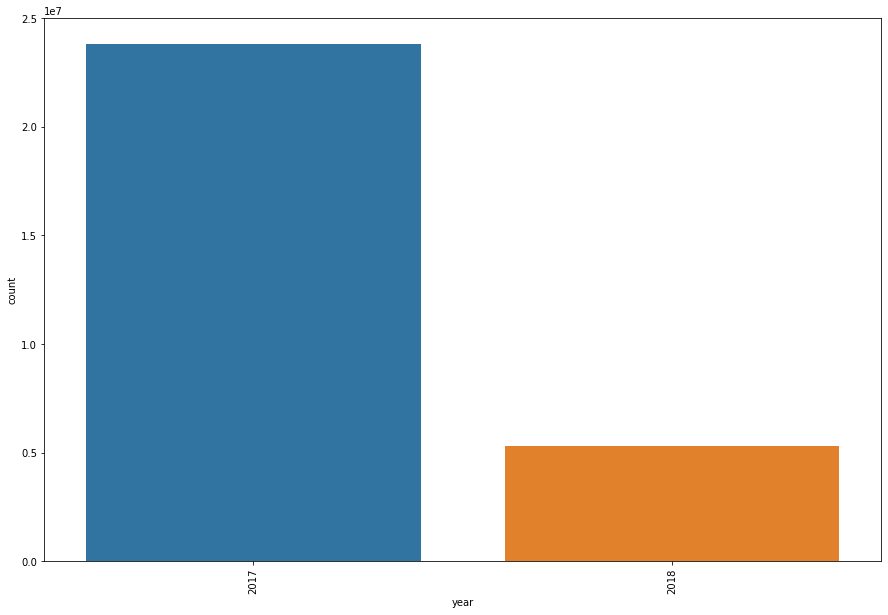

In [72]:
plotBarPlot(temp_df,'year')
year_mode = computeCategoricalAggr(nout_train_df,temp_df,'year',mode_lambda_func,'mode')
year_nunique = computeCategoricalAggr(nout_train_df,temp_df,'year',nunique_lambda_func,'nunique')

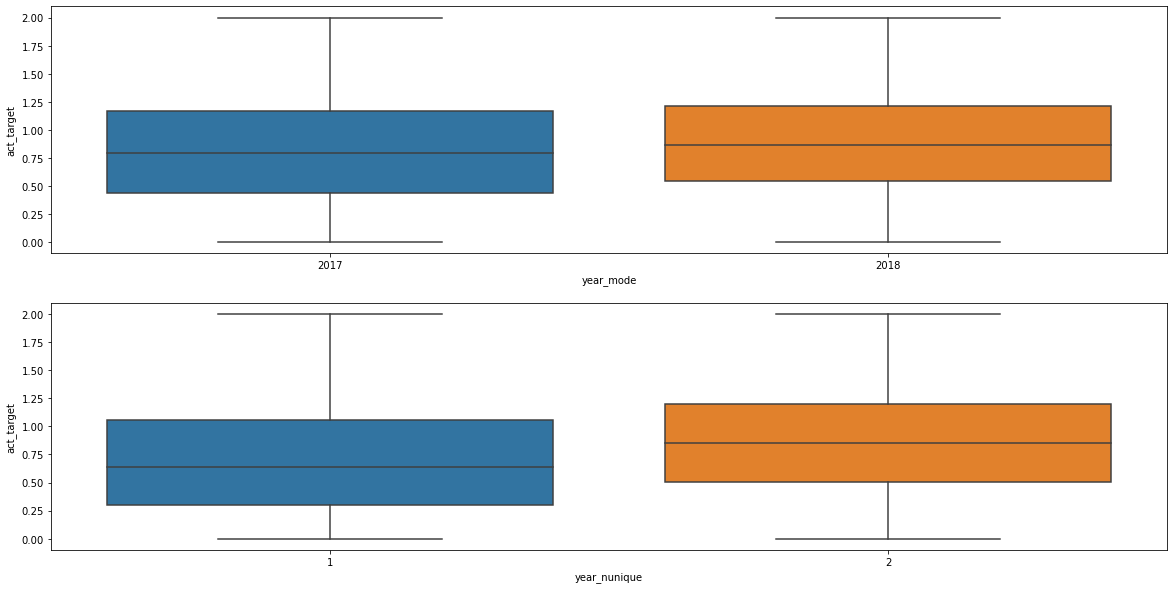

In [73]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols = 1,figsize = (20,10))
sns.boxplot(x='year_mode',y = 'act_target',data = year_mode,ax = ax1)
sns.boxplot(x='year_nunique',y = 'act_target',data = year_nunique,ax = ax2)

In [20]:
aggr_col = 'new_purchase_amount'
aggr_funcs = ['min','max','median','sum']

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.44s/it]


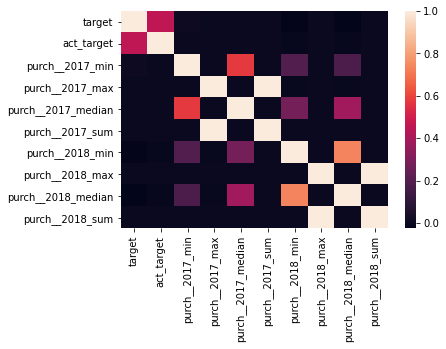

In [24]:
sns.heatmap(generateAggrColumns(nout_train_df,temp_df,'year',aggr_col,aggr_funcs,'purch_').corr())

## Analysis
* It's the same as that for other purchase date features.
* For numerical aggregation on purchase_amount there is no strong correlation between the aggregated feature and actual target.

## 9.6. Objective : Check relation between purchase_weekday and actual target

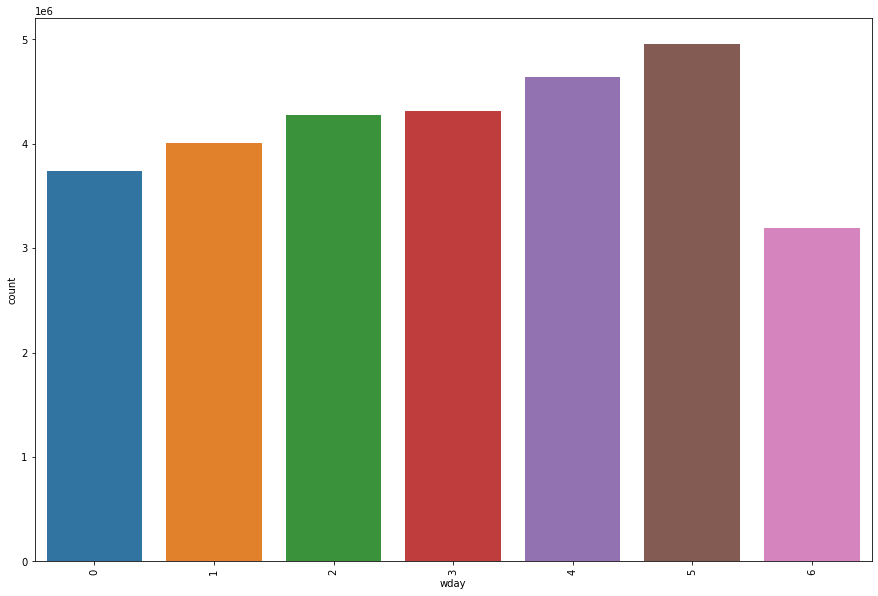

In [26]:
plotBarPlot(temp_df,'wday')
wday_mode = computeCategoricalAggr(nout_train_df,temp_df,'wday',mode_lambda_func,'mode')
wday_nunique = computeCategoricalAggr(nout_train_df,temp_df,'wday',nunique_lambda_func,'nunique')

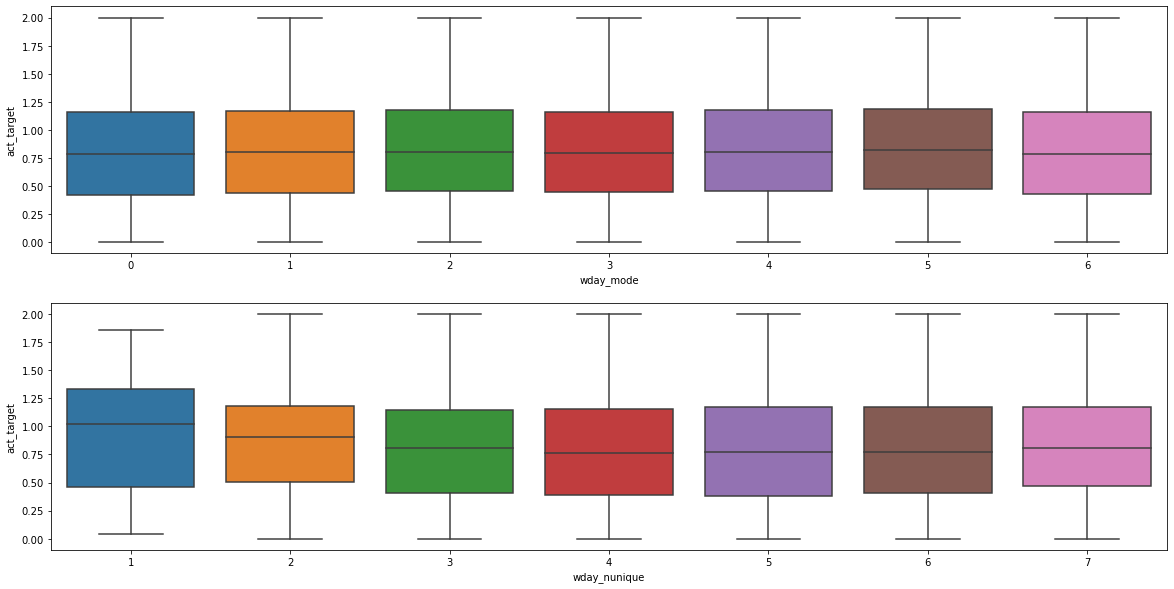

In [27]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols = 1,figsize = (20,10))
sns.boxplot(x='wday_mode',y = 'act_target',data = wday_mode,ax = ax1)
sns.boxplot(x='wday_nunique',y = 'act_target',data = wday_nunique,ax = ax2)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.12s/it]


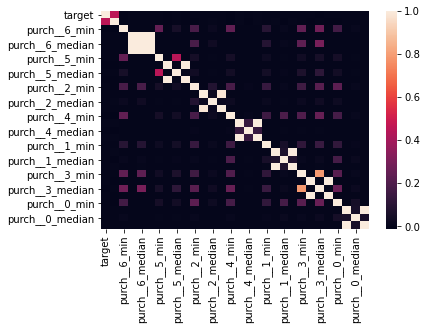

In [28]:
sns.heatmap(generateAggrColumns(nout_train_df,temp_df,'wday',aggr_col,aggr_funcs,'purch_').corr())

## Analysis
* It's the same as that for other purchase date features.
* For numerical aggregation on purchase_amount there is no strong correlation between the aggregated feature and actual target.

### Since the dataframe is very large applying any kind of aggregation takes a lot of time.
* So I am taking just few 100 cardId's and will try to analyze them for purchase amount and purchase_date attributes

In [8]:
## Creating sampled_df with historical transactions for 100 cardId's
def createSampledHistDf(temp_df,card_ids,sortby):
    """
        Sampling historical transactions based on 
        card_ids recieved in input parameter
        and sorting them by given list of columns
    """
    sampled_card_ids = temp_df[['card_id']].sample(n=100)
    sampled_df = temp_df[temp_df['card_id'].isin(card_ids)].copy()
    sampled_df.sort_values(by = sortby,inplace = True)
    return sampled_df

In [9]:
## Picking train_df rows which contain this cardId's
def createSampledTrainDf(temp_df,card_ids):
    """
        Sampling train_df based on card_ids
    """
    s_train_df = temp_df[temp_df['card_id'].isin(card_ids)].copy()
    return s_train_df

In [10]:
temp_df = hist_df[['card_id','installments','new_purchase_amount','purchase_date','month_lag']].copy()

In [16]:
card_ids = temp_df['card_id'].sample(n=100).values
s_hist_df = createSampledHistDf(temp_df,card_ids,sortby = ['card_id','purchase_date'])
s_train_df = createSampledTrainDf(train_df,card_ids)

## 9.7. Objective: Creating Elapsed time feature and checking relation of aggregate feature on elapsed time with target variable

In [ ]:
## let's add a column named elapsed time and see if it provides any useful information
s_hist_df['purchase_date'] = pd.to_datetime(s_hist_df['purchase_date'])
s_hist_df['elapsed_time'] = s_hist_df['purchase_date'].diff()

In [17]:
s_hist_df.head()

,card_id,installments,new_purchase_amount,purchase_date,month_lag,elapsed_time
10268268,C_ID_068f130de6,1,88.129997,2017-01-06 18:04:58,-12,NaT
10268253,C_ID_068f130de6,1,40.000000,2017-01-06 18:14:15,-12,0 days 00:09:17
10268273,C_ID_068f130de6,1,40.000000,2017-01-06 18:14:47,-12,0 days 00:00:32
10268284,C_ID_068f130de6,1,31.059999,2017-01-18 08:14:06,-12,11 days 13:59:19
10268295,C_ID_068f130de6,1,20.200001,2017-01-21 08:40:18,-12,3 days 00:26:12


In [18]:
s_hist_df['elapsed_time'] = s_hist_df['elapsed_time'].apply(lambda x : str(x).split(' ')[0])

In [19]:
s_hist_df.head()

,card_id,installments,new_purchase_amount,purchase_date,month_lag,elapsed_time
10268268,C_ID_068f130de6,1,88.129997,2017-01-06 18:04:58,-12,NaT
10268253,C_ID_068f130de6,1,40.000000,2017-01-06 18:14:15,-12,0
10268273,C_ID_068f130de6,1,40.000000,2017-01-06 18:14:47,-12,0
10268284,C_ID_068f130de6,1,31.059999,2017-01-18 08:14:06,-12,11
10268295,C_ID_068f130de6,1,20.200001,2017-01-21 08:40:18,-12,3


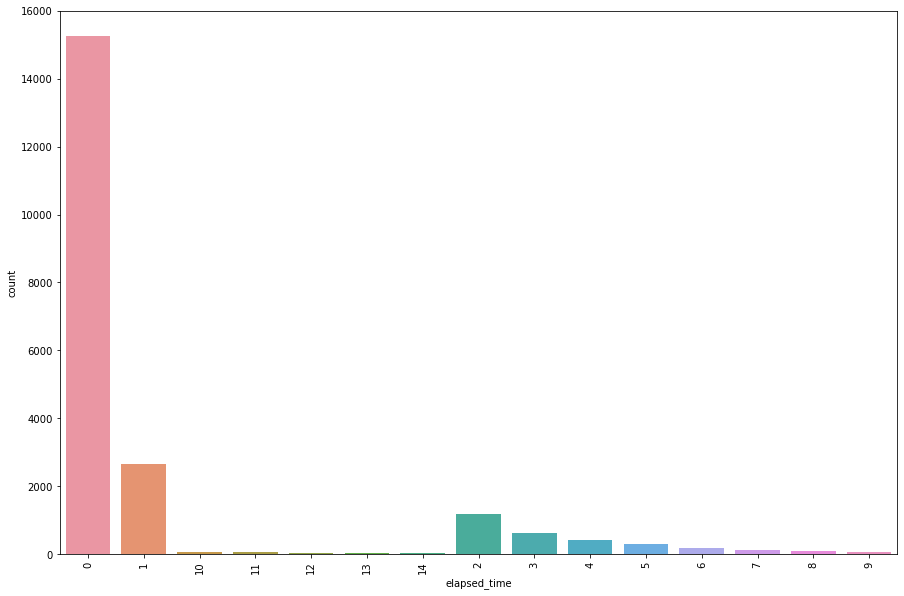

In [23]:
## Selecting quantile as 90 because majority of the values occur very few times
plotBarPlot(s_hist_df,'elapsed_time',90)

## Analysis
* Majority of the elapsed time value is 0.

In [24]:
## Referring to previous two lambda functions
elapsed_mode_df = computeCategoricalAggr(s_train_df,s_hist_df,aggr_cat_col='elapsed_time',lambda_func=mode_lambda_func,col_suffix='mode')
elapsed_nunique_df = computeCategoricalAggr(s_train_df,s_hist_df,aggr_cat_col='elapsed_time',lambda_func=nunique_lambda_func,col_suffix='nunique')

In [25]:
elapsed_mode_df.head()

,card_id,target,act_target,elapsed_time_mode
0,C_ID_39a8e9745b,-0.204427,0.867883,0
1,C_ID_6658d58cf4,-0.193815,0.874290,0
2,C_ID_729e3934f4,0.406825,1.325765,0
3,C_ID_b6bb1fc4e9,-0.625246,0.648309,0
4,C_ID_3b626d74bf,-0.476626,0.718656,0


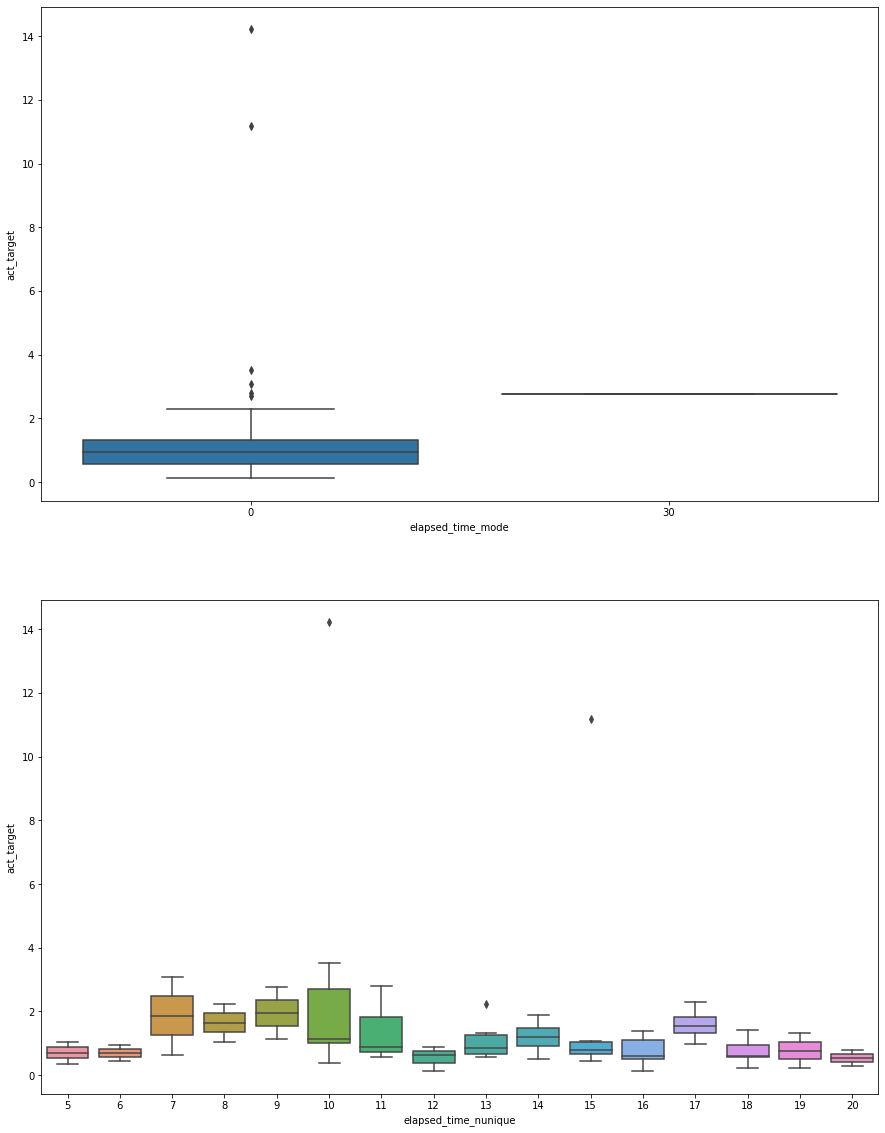

In [26]:
fig,(ax1,ax2) = plt.subplots(nrows = 2,ncols = 1,figsize=(15,20))
sns.boxplot('elapsed_time_mode','act_target',data=elapsed_mode_df,ax=ax1)
sns.boxplot('elapsed_time_nunique','act_target',data=elapsed_nunique_df,ax=ax2)

## Analysis
* For majority of the transactions the elapsed time is 0 and 1.
* When mode of the elapsed time is taken with groupby card_id we can see a clear difference in distribution of target variables for two of the values.
* Elapsed time with nunique as a aggregated feature contains some deviation of distribution wrt target variable.

## Conclusion
* These features will be useful for our feature set.

## 10. Objective : Next is creating time lag features wrt to purchase amount and checking relation of aggregated features with target variable

## Writing a generic piece of code to create these features.
* Use sampled transactions from historical transactions and corresponding cardid's from train data.
* Since a lot of card_id's are not present in train data, only a few of them will overlap.
* Create aggregate features like min,max,mean,median and sum (groupedBy = 'cardId','month_lag') on purchase_amount.
* Create lag features for each of this purchase_amounts groupedby(month_lag's)
* find consecutive and non-consecutive(2 month gap) purchase_amount ratio's.
* Create this for each of the aggregated features and plot a heatmap to check if there is any linear correlation with act_target.

In [5]:
def createPurchaseAmountLagFeatures(sampled_df,aggr_funcs):
    """
        Creating dataframe with column for different purchase amount ratio's aggregated by different
        statistical functions and grouped by different month_lag's
    """
    aggr_dict = {'new_purchase_amount' : aggr_funcs}
    aggr_df = sampled_df.groupby(['card_id','month_lag']).agg(aggr_dict).reset_index().rename(columns = {'new_purchase_amount' : 'np_amount'})
    aggr_df.columns = ['_'.join(col).strip('_') for col in aggr_df.columns.values]
    
    #List to create column month_lag
    month_lag = aggr_df['month_lag'].unique()
    # creating list of column names with np_amount aggregated features
    np_amount_cols = ['np_amount_' + func for func in aggr_funcs] 

    first_run = True #Used as a boolean to decide if dataframe has to be merged in first instance or not
    merge_df = pd.DataFrame() #For merging columns with different aggregate functions on purchase amount with month lag information
    
    ## Create lag features for different aggregated np_amount
    for col in np_amount_cols:
        for lag in month_lag:
            if lag == 0:
                temp_lag_df = aggr_df[aggr_df['month_lag'] == lag][['card_id',col,'month_lag']].rename(columns={col : col + "_0"})
            else:
                temp_lag_df = aggr_df[aggr_df['month_lag'] == lag][['card_id',col]].rename(columns={col : col + "_" + str(lag)[1:]})
            
            if first_run:
                merge_df = temp_lag_df
                first_run = False
            else:
                merge_df = pd.merge(merge_df,temp_lag_df,on='card_id',how='outer')
    
    return merge_df

In [6]:
def createPurchaseAmountRatioFeatures(df,aggr_funcs,lag_shift):
    
    """
    Create purchase amount ratios with different different month lags
    if lag_shft = 2 then purchase_amount_ratio = purchase_amount_over month_lag_0/purchase_amount over month_lag_2
    basically it's a ratio of future purchase_amount/ past purchase_amount
    """
    month_lag = df['month_lag'].unique()
    np_amount_cols = ['np_amount_' + func for func in aggr_funcs] 

    final_df = pd.DataFrame() #For creating final dataframe with ratio of purchase amount features obtained from above dataframe
    ## Creating ratios of these lag features 
    for col in np_amount_cols:
        for lag in range(12):
            future_col = col + '_'+ str(lag)
            past_col = col + '_' + str(lag+lag_shift)
            final_df[col + '_' + str(lag) + '_' + str(lag+lag_shift)] = df[future_col]/df[past_col]
    final_df['card_id'] = df['card_id']
    ## Creating time
    return final_df

In [7]:
## Aggregate functions to work on
aggr_funcs = ['min','max','mean','sum','median']

## 10.1 Objective : Create purchase amount ratio features and check their correlation with target variable

In [17]:
purch_lag_df = createPurchaseAmountLagFeatures(s_hist_df,aggr_funcs)
purch_ratio_df = createPurchaseAmountRatioFeatures(purch_lag_df,aggr_funcs,2)
purch_ratio_df = pd.merge(s_train_df,purch_ratio_df,on='card_id',how='left')
purch_ratio_df.head(10)

,card_id,target,act_target,np_amount_min_0_2,np_amount_min_1_3,np_amount_min_2_4,np_amount_min_3_5,np_amount_min_4_6,np_amount_min_5_7,np_amount_min_6_8,...,np_amount_median_2_4,np_amount_median_3_5,np_amount_median_4_6,np_amount_median_5_7,np_amount_median_6_8,np_amount_median_7_9,np_amount_median_8_10,np_amount_median_9_11,np_amount_median_10_12,np_amount_median_11_13
0,C_ID_ac903af10d,0.062275,1.044111,2.000000,0.195000,0.312500,3.100775,0.200000,645.000000,3.333333,...,0.356916,1.594588,1.779283,0.364338,0.951141,1.328588,1.775924,0.734175,0.699167,2.174364
1,C_ID_44673d2223,-3.832413,0.070199,0.787402,0.653381,0.601225,NaN,NaN,NaN,NaN,...,0.589758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C_ID_c51fbb75ae,0.681320,1.603606,4.191617,0.834615,0.167839,0.724234,0.523684,0.854762,8.444445,...,0.621687,0.348622,0.927299,2.858433,2.077873,1.683592,NaN,NaN,NaN,NaN
3,C_ID_2a663b79ee,-1.061429,0.479157,4.100000,0.410959,0.095238,1.355714,1.605505,1.166667,1.453333,...,0.874278,2.145161,2.399340,0.567558,1.052083,NaN,NaN,NaN,NaN,NaN
4,C_ID_ac164eb5c0,-0.484612,0.714689,32.459999,0.592593,0.074074,1.000000,1.687500,1.687500,0.038945,...,1.140286,1.027292,1.121734,1.250483,0.060862,NaN,NaN,NaN,NaN,NaN
5,C_ID_9042adb9bb,-0.278493,0.824452,2.232143,1.503759,0.280000,1.017857,0.778210,0.982456,1.285000,...,1.088777,1.110855,1.382300,0.939370,0.825265,1.237817,0.773399,1.154430,1.595076,0.816866
6,C_ID_275a41ae9a,-0.416451,0.749266,1.000000,0.307692,0.476191,2.600000,0.965517,0.555556,2.081340,...,0.913779,1.083744,1.475886,0.975962,0.871392,1.040000,0.858696,1.026694,1.534356,0.885455
7,C_ID_d003e00b4a,-1.227943,0.426926,0.132013,2.121212,2.272500,NaN,1.680672,NaN,0.991667,...,1.293898,NaN,1.406100,NaN,1.084970,1.281956,0.993976,1.337494,0.846939,0.040610
8,C_ID_babafa0fcb,2.565194,5.918345,NaN,0.252525,3.000000,3.300000,1.666667,1.200000,0.400000,...,1.178774,1.562189,1.284849,1.049243,0.780142,0.487819,1.790476,1.476501,0.166843,NaN
9,C_ID_5e4e91ced2,1.422866,2.681176,7.747495,0.199199,3.868217,NaN,NaN,NaN,NaN,...,0.400401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


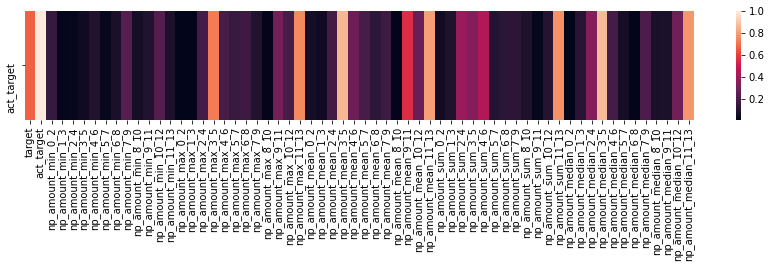

In [19]:
fig,ax = plt.subplots(figsize = (15,2))
sns.heatmap(abs(purch_ratio_df.corr())[['act_target']].T,ax=ax)

## Analysis
* We can see strong linear correlation of the above aggregated purchase_amount ratios over different month lags with target variable.
* These features should be the most important ones.

## 10.2. Objective : Create Purchase_amount simple window average features and check their correlation with target variable

In [20]:
## Creating simple window averaging over previous month lags
def createPurchaseAmountWindowAvg(df,aggr_funcs,lag_shift):
    
    """
    Creating purchase amount average over a window of lag_shift specified
    For instance : if lag_shift = 2
    then purchase_amount_avg_0_2 = (purchase_amount_0 + purchase_amount_1 + purchase_amount_2)/3
         purchase_amount_avg_1_3 = (purchase_amount_1 + purchase_amount_2 + purchase_amount_3)/3
    """
    
    
    
    month_lag = df['month_lag'].unique()
    np_amount_cols = ['np_amount_' + func for func in aggr_funcs] 
    
    
    #For creating final dataframe with window average of purchase amount features obtained from input dataframe
    final_df = pd.DataFrame() 
    ## Calculating simple window average of these lag features 
    for col in np_amount_cols:
        for lag in range(14-lag_shift):
            avg = 0
            for i in range(lag,lag_shift+1):
                avg = avg + df[col + '_'+ str(i)]
            avg = avg/(lag_shift+1)   
            final_df[col + '_' + str(lag) + '_' + str(lag+lag_shift) + '_avg'] = avg

    final_df['card_id'] = df['card_id']
    return final_df

In [21]:
purch_lag_df = createPurchaseAmountLagFeatures(s_hist_df,aggr_funcs)
purch_lag_avg2_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,2)
purch_lag_avg3_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,3)
purch_lag_avg4_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,4)

purch_lag_avg5_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,5)
purch_lag_avg6_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,6)
purch_lag_avg7_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,7)

purch_lag_avg8_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,8)
purch_lag_avg9_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,9)
purch_lag_avg10_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,10)

purch_lag_avg11_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,11)
purch_lag_avg12_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,12)
purch_lag_avg13_df = createPurchaseAmountWindowAvg(purch_lag_df,aggr_funcs,13)

In [22]:
purch_lag_avg2_df = pd.merge(s_train_df,purch_lag_avg2_df,on='card_id',how='left')
purch_lag_avg3_df = pd.merge(s_train_df,purch_lag_avg3_df,on='card_id',how='left')
purch_lag_avg4_df = pd.merge(s_train_df,purch_lag_avg4_df,on='card_id',how='left')

purch_lag_avg5_df = pd.merge(s_train_df,purch_lag_avg5_df,on='card_id',how='left')
purch_lag_avg6_df = pd.merge(s_train_df,purch_lag_avg6_df,on='card_id',how='left')
purch_lag_avg7_df = pd.merge(s_train_df,purch_lag_avg7_df,on='card_id',how='left')

purch_lag_avg8_df = pd.merge(s_train_df,purch_lag_avg8_df,on='card_id',how='left')
purch_lag_avg9_df = pd.merge(s_train_df,purch_lag_avg9_df,on='card_id',how='left')
purch_lag_avg10_df = pd.merge(s_train_df,purch_lag_avg10_df,on='card_id',how='left')

purch_lag_avg11_df = pd.merge(s_train_df,purch_lag_avg11_df,on='card_id',how='left')
purch_lag_avg12_df = pd.merge(s_train_df,purch_lag_avg12_df,on='card_id',how='left')
purch_lag_avg13_df = pd.merge(s_train_df,purch_lag_avg13_df,on='card_id',how='left')

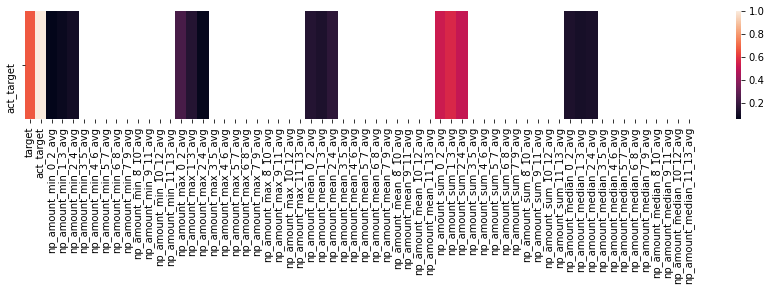

In [23]:
fig,ax = plt.subplots(figsize=(15,2))
sns.heatmap(abs(purch_lag_avg2_df.corr())[['act_target']].T,ax = ax)

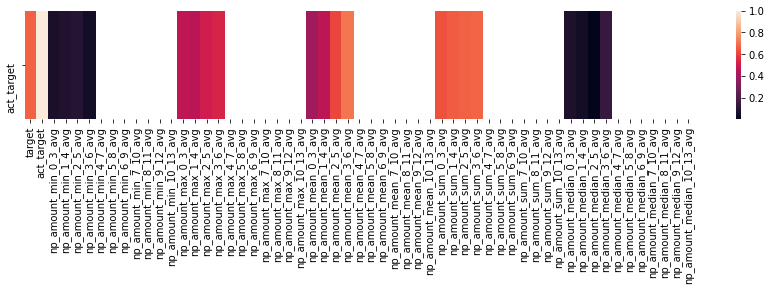

In [24]:
fig,ax = plt.subplots(figsize=(15,2))
sns.heatmap(abs(purch_lag_avg3_df.corr())[['act_target']].T,ax = ax)

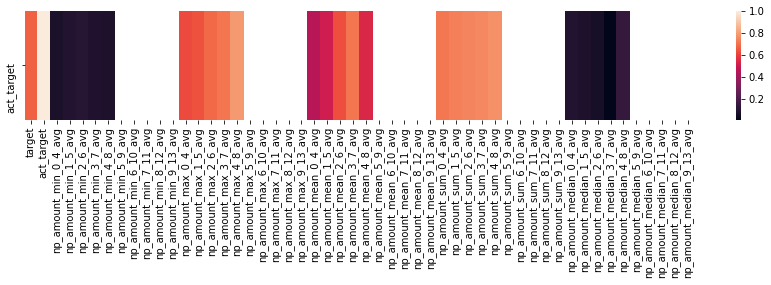

In [25]:
fig,ax = plt.subplots(figsize=(15,2))
sns.heatmap(abs(purch_lag_avg4_df.corr())[['act_target']].T,ax = ax)

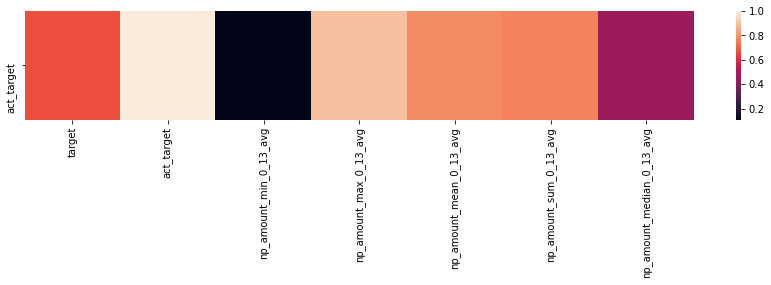

In [26]:
fig,ax = plt.subplots(figsize=(15,2))
sns.heatmap(abs(purch_lag_avg13_df.corr())[['act_target']].T,ax = ax)

## Analysis
* Some of the features created using simple window averaging show strong correlation with target variable.

## Conclusion
* These features are definitely the important one's and are going to improve our feature set.

## 11. Objective : Explore Installments

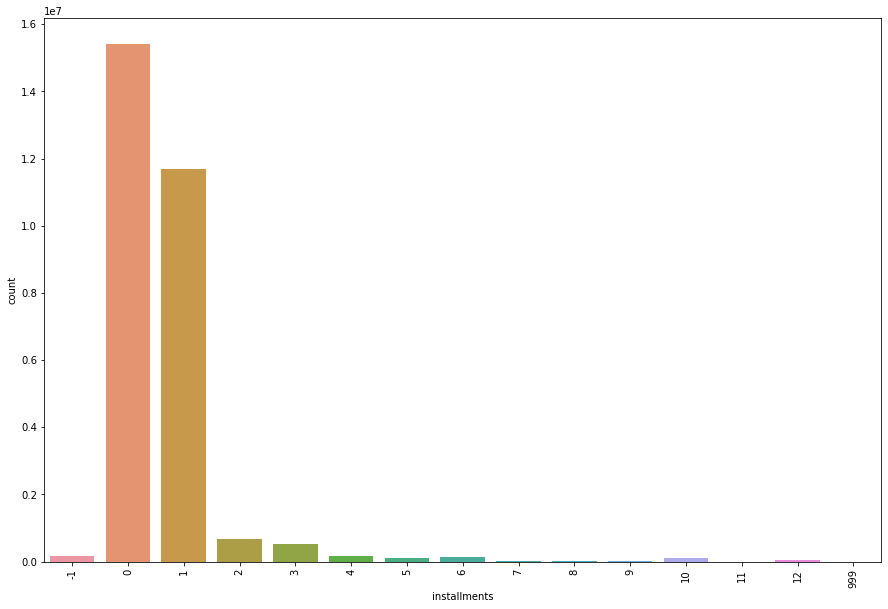

In [81]:
plotBarPlot(temp_df,'installments')

## Analysis
* Maximum number of installments are 0 and 1 which suggests that majority of the items are bought in one go.
* There are few transactions which contain values of -1 and 999 which don't represent the actual installment numbers.

In [82]:
installments_mode_df = computeCategoricalAggr(nout_train_df,temp_df,'installments',mode_lambda_func,'mode')
installments_nunique_df = computeCategoricalAggr(nout_train_df,temp_df,'installments',nunique_lambda_func,'nunique')

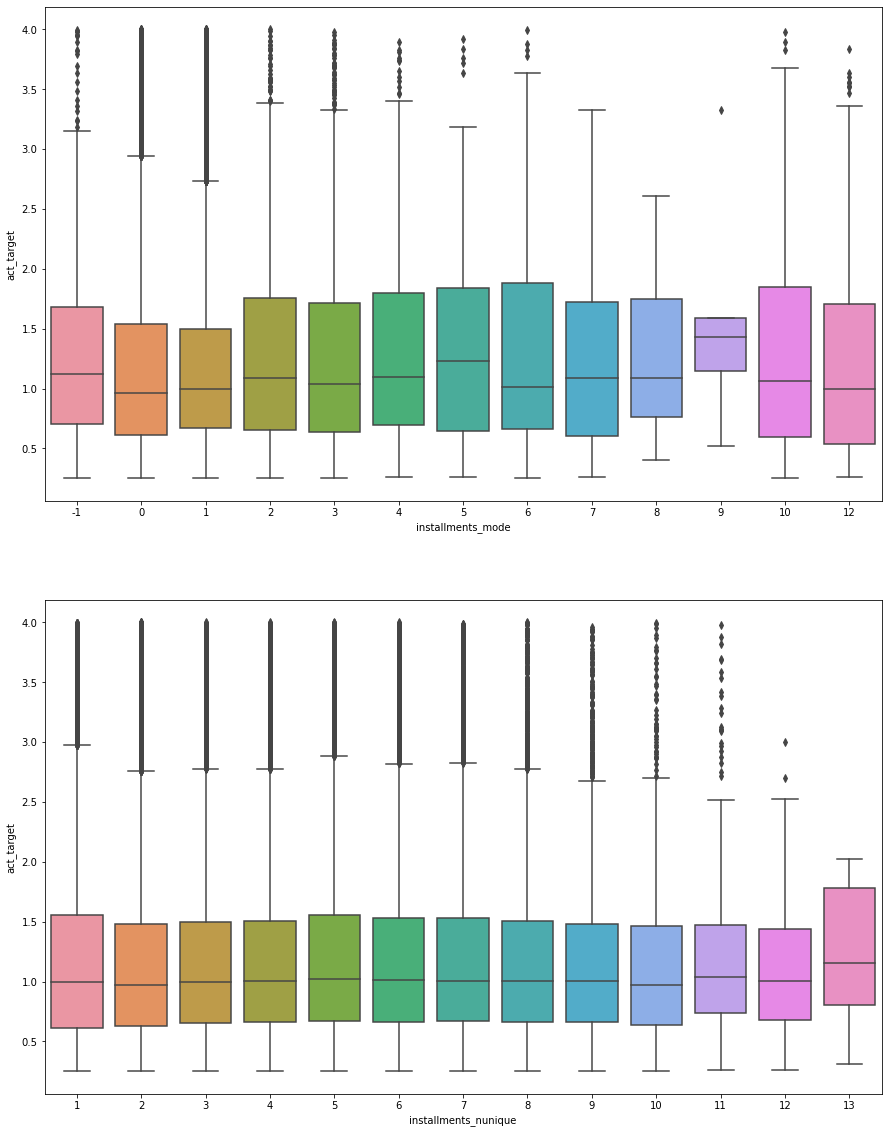

In [84]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize = (15,20))

sns.boxplot('installments_mode','act_target',data=installments_mode_df,ax = ax1)
sns.boxplot('installments_nunique','act_target',data=installments_nunique_df,ax = ax2)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.21s/it]


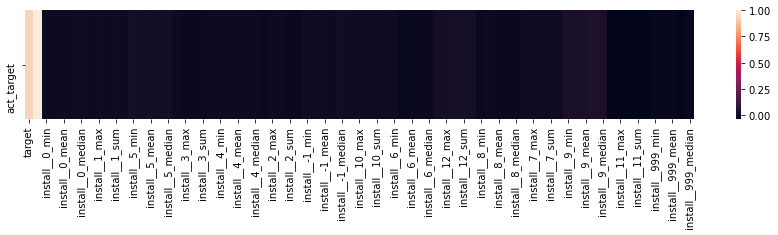

In [39]:
fig,ax = plt.subplots(figsize = (15,2))
sns.heatmap(generateAggrColumns(nout_train_df,temp_df,'installments','new_purchase_amount',aggr_funcs,'install_').corr()[['act_target']].T,ax = ax)

## Analysis
* While categorical aggregation with mode and unique seem to be useful.
* For numerical aggregation on installment with purchase amount there is no strong correlation between the aggregated feature and actual target.

## Purchase Dates

In [4]:
purchase_date_df = hist_df[['card_id','purchase_date']]

temp_df = pd.DataFrame()
temp_df['card_id'] = purchase_date_df['card_id']
temp_df['purchase_date'] = pd.to_datetime(purchase_date_df['purchase_date'])
temp_df['day'] = temp_df['purchase_date'].dt.day
temp_df['wday'] = temp_df['purchase_date'].dt.weekday
temp_df['year'] = temp_df['purchase_date'].dt.year
temp_df['month'] = temp_df['purchase_date'].dt.month

In [5]:
del(hist_df)

In [6]:
temp_df['date'] = temp_df['purchase_date'].dt.date

In [7]:
temp_df.head()

,card_id,purchase_date,day,wday,year,month,date
0,C_ID_4e6213e9bc,2017-06-25 15:33:07,25,6,2017,6,2017-06-25
1,C_ID_4e6213e9bc,2017-07-15 12:10:45,15,5,2017,7,2017-07-15
2,C_ID_4e6213e9bc,2017-08-09 22:04:29,9,2,2017,8,2017-08-09
3,C_ID_4e6213e9bc,2017-09-02 10:06:26,2,5,2017,9,2017-09-02
4,C_ID_4e6213e9bc,2017-03-10 01:14:19,10,4,2017,3,2017-03-10


In [8]:
temp_df.iloc[:100]

,card_id,purchase_date,day,wday,year,month,date
0,C_ID_4e6213e9bc,2017-06-25 15:33:07,25,6,2017,6,2017-06-25
1,C_ID_4e6213e9bc,2017-07-15 12:10:45,15,5,2017,7,2017-07-15
2,C_ID_4e6213e9bc,2017-08-09 22:04:29,9,2,2017,8,2017-08-09
3,C_ID_4e6213e9bc,2017-09-02 10:06:26,2,5,2017,9,2017-09-02
4,C_ID_4e6213e9bc,2017-03-10 01:14:19,10,4,2017,3,2017-03-10
...,...,...,...,...,...,...,...
95,C_ID_4e6213e9bc,2018-02-04 13:43:21,4,6,2018,2,2018-02-04
96,C_ID_4e6213e9bc,2017-08-11 10:40:29,11,4,2017,8,2017-08-11
97,C_ID_4e6213e9bc,2017-08-11 13:02:59,11,4,2017,8,2017-08-11
98,C_ID_4e6213e9bc,2017-08-04 15:48:28,4,4,2017,8,2017-08-04


In [19]:
s_hist_df = temp_df.sample(frac = 0.001)

In [20]:
s_hist_df.shape

(29112, 7)

In [18]:
def createDateRelatedBoolFeat(temp_df):
    temp_df['is_purchase_month_end'] = temp_df.apply(lambda x : calendar.monthrange(x['year'],x['month'])[1] == x['day'],axis=1)
    temp_df['is_purchase_month_start'] = temp_df.apply(lambda x : x['day'] == 1,axis=1)
    temp_df['is_quarter_month_start'] = temp_df.apply(lambda x : (x['month'] % 3 == 1) & (x['day'] == 1),axis=1)
    temp_df['is_purchase_quarter_end'] = temp_df.apply(lambda x : (x['month'] % 3 == 1) & (calendar.monthrange(x['year'],x['month'])[1] == x['day']),axis=1)
    temp_df['is_purchase_year_end'] = temp_df.apply(lambda x : (x['month'] % 12 == 0) & (calendar.monthrange(x['year'],x['month'])[1] == x['day']),axis=1)
    temp_df['is_purchase_year_start'] = temp_df.apply(lambda x : (x['month'] % 12 == 1) & (x['day'] == 1),axis=1)
    temp_df['is_christmas'] = temp_df.apply(lambda x : (x['month'] == 12) & (x['day'] == 25),axis=1)
    
    temp_df['is_mothers_day'] = temp_df.apply(lambda x : (x['date'] == datetime.datetime(2017,5,14)) | (x['date'] == datetime.datetime(2018,5,13)),axis = 1)
    temp_df['is_childrens_day'] = temp_df.apply(lambda x : (x['date'] == datetime.datetime(2017,11,24)),axis = 1)
    temp_df['is_valentines_day'] = temp_df.apply(lambda x : (x['date'] == datetime.datetime(2017,2,14)),axis = 1)
    temp_df['is_fathers_day'] = temp_df.apply(lambda x : (x['date'] == datetime.datetime(2017,6,18)),axis = 1)
    return temp_df

In [21]:
s_hist_df = createDateRelatedBoolFeat(s_hist_df)
s_hist_df.head()

,card_id,purchase_date,day,wday,year,month,date,is_purchase_month_end,is_purchase_month_start,is_quarter_month_start,is_purchase_quarter_end,is_purchase_year_end,is_purchase_year_start,is_christmas,is_mothers_day,is_childrens_day,is_valentines_day,is_fathers_day
9085680,C_ID_0e351d378c,2018-01-07 11:35:00,7,6,2018,1,2018-01-07,False,False,False,False,False,False,False,False,False,False,False
27472339,C_ID_2eea87f9f2,2018-01-02 17:21:14,2,1,2018,1,2018-01-02,False,False,False,False,False,False,False,False,False,False,False
3395557,C_ID_5aabde4f19,2017-12-20 16:26:22,20,2,2017,12,2017-12-20,False,False,False,False,False,False,False,False,False,False,False
291330,C_ID_c2a213d93e,2017-09-01 23:12:10,1,4,2017,9,2017-09-01,False,True,False,False,False,False,False,False,False,False,False
3793711,C_ID_99f1bc6418,2017-11-01 20:00:58,1,2,2017,11,2017-11-01,False,True,False,False,False,False,False,False,False,False,False


## Listing down all the analysis
### Two types of categorical aggregation
* Groupby categorical variable's category and aggregate over numerical features(like purchase amount)
### How to check if it's useful? 
* Check correlation with target variable(HeatMap helps to observe)
### Taking Each of the Categorical feature, grouping by cardId and aggregating by mean,median,mode,count,nunique<br>
* Using Box plots to see variations of the aggregated features with actual target.
* Observed this variations for Category_1,Category_2,Category_3,city_id,state_id.
* Observed some variations for the newly formed features.
* Explored Authorized flag in the same manner, Nothing significant observed.
* Explored other categorical features like merchant_category_id,subsector_id.
			
### Exploring Numerical and datetime features	
* Converting Date string(purchase_date) to Datetime object.
* Obtaining other deal of information from datetime like day,week,month and year.
* Treating them as a categorical data and performed categorical aggregation.
### Analysis of Month Lag 
* A lag of 0 suggests latest month of transaction whereas a lag of -1 represents transactions of previous month wrt reference date.
* There have been more recent purchases as compared to previous months.
* Some variance wrt to mode and nunique features was observed.
### Elapsed time
* Elapsed time = difference between consecutive purchase dates,measured in days
* Code : hist_df['elapsed_time'] = hist_df['purchase_date'].diff()
* Majority of the elapsed time value is 0.
* Treating elapsed time as a categorical feature and performing aggregation over it
		
	### Analysis
	* For majority of the transactions the elapsed time is 0 and 1.
	* When mode of the elapsed time is taken with groupby card_id we can see a clear difference in distribution of target variables for two of the values.	
	* Elapsed time with nunique as a aggregated feature contains some deviation of distribution wrt target variable.
		
	### Conclusion
	* These features will be useful for our feature set.
		
### Creating purchase amount features wrt lag
* Reason to delve deep into the purchase amount features is because we want to find the loyalty score.
* This loyalty score should be more or less dependent on the purchase amount features i.e based on the customer's purchasing habits the company must assign a loyalty score
* So we try to take ratios of aggregated purchase amounts(min,max,mean) grouped by different month lags and card_ids.
* Features that we get are somewhat of this kind
	np_amount_min_0_2	np_amount_min_1_3	np_amount_min_2_4	np_amount_min_3_5
	This sort of features have proven to be useful in predicting the loyalty score as suggested in some kernel.
		
	### Analysis
	* We can see strong linear correlation of the above aggregated purchase_amount ratios over different month lags with target variable.(Heat map)
	* These features should be the most important ones.
			
### Simple window averaging over different time lags
* Creating purchase amount average over a window of lag_shift specified
* For instance : if lag_shift = 2
* purchase_amount_avg_0_2 = (purchase_amount_0 + purchase_amount_1 + purchase_amount_2)/3
* purchase_amount_avg_1_3 = (purchase_amount_1 + purchase_amount_2 + purchase_amount_3)/3
* Similarly creating windows of different sizes and observing their correlation with the target variable.
	
    ### Analysis
	* There is strong correlation between this window averaged feature and target variable.

### Explore Installments
* Treated it as a categorical feature
* Majority of the values where 0 and 1 suggesting that majority of the items where purchased in one go or not more than one installment
* Created statistically aggregated features over them
	
    ### Analysis
	* Developed features which were not of much use.
	
### Created Boolean features based on dates
* is_purchase_month_end,month_start,
* is_quarter_month_start,end
* is_purchase_year_start,end
* is_mothers_day,is_childrensd_day,is_valentines_day,is_fathers_day,is_christmas